# Práctica: Técnicas de agrupación (clustering) 

#### Índice
* [Introducción y objetivos](#Introducción-y-objetivos)
* [Definición del problema](#Definición-del-problema)
* [Análisis exploratorio de los datos](#Análisis-exploratorio-de-los-datos)
    * [Descripción de los datos](#Descripción-de-los-datos)
    * [Procesamiento de los datos](#Procesamiento-de-los-datos)
* [Metodología](#Metodología)
* [Experimentación y discusión de resultados](#Experimentación-y-discusión-de-resultados)
    * [Formateo de datos y normalización](#Formateo-de-datos-y-normalización)
    * [KMeans](#KMeans)
    * [DBSCAN](#DBSCAN)
* [Conclusiones](#Conclusiones)
* [Bibliografía](#Bibliografía)

## Introducción y objetivos

Los algoritmos de clustering son unas de las principales técnicas aplicadas al aprendizaje no supervisado. Es especialmente útil para encontrar estructuras en los datos y medir la similitud entre ellos, lo que se conoce como aprendizaje descriptivo. En este trabajo se pretende abordar un problema muy concreto, que trata sobre la reordenación de los valores de ciertas variables que se encuentran desordenados, con el fin de que los grupos de similitud encontrados puedan mejorar el rendimiento de un clasificador en un problema de clasificación supervisada.

Los objetivos principales para este trabajo son:
* Detallar y describir el problema propuesto.
* Analizar el conjunto de datos y formular hipótesis sobre estos.
* En base a lo anterior, estudiar la posible solucción al problema escogiendo de manera justificada los métodos que se van a emplear.
* Aplicar los algoritmos seleccionados, estudiar las relacciones encontradas en los datos y comparar los algoritmos mediante medidas de calidad de los clusters formados.
* Analizar los resultados obtenidos y formular conclusiones a partir de estos.

## Definición del problema

El problema planteado viene dado por el dataset escogido "Motion Capture Hand Postures Data Set" (https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#). En el que se utilizó un sistema de cámaras de captura de movimiento Vicon para detectar, mediante unos marcadores situados en un guante para la mano izquierda, cinco posturas diferentes efectuadas por 15 usuarios.

Se utilizó un patrón rígido en la parte trasera del guante para que el sistema estableciera las coordenadas locales de la mano, y once marcadores en los dedos del guante: tres para el pulgar, uno encima de la uña, y los otros dos en las articulaciones de este; y dos marcadores para cada dedo, uno localizado en encima de la uña de cada uno y otro en la articulación entre las falanges medias y las falanges proximales.

<div>
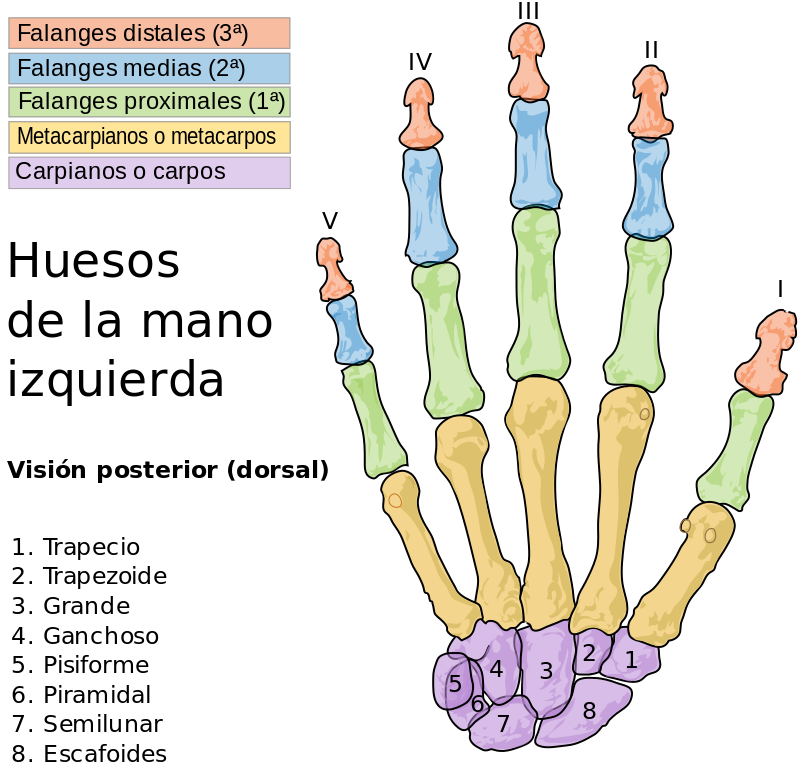
</div>

El dataset consta de las posiciones de los once marcadores de los dedos, aunque estas posiciones no están etiquetadas ya que no fueron rastreadas, lo que quiere decir que no hay correspondencia entre marcadores para dos observaciones diferentes; es decir, si para una instancia el punto 0 corresponde con el marcador de la uña del dedo índice, el mismo punto para la siguiente observación puede corresponder a cualquier otro marcador. En definitiva, los valores de las variables que representan cada punto están desordenadas. Además debido a la resolución de captura, y que para ciertas posiciones algunos marcadores están ocultos por la propia mano, el dataset contará con una gran cantidad de valores perdidos. Por último cabe destacar que debido a artefactos en el proceso de grabación y reconstrucción del software de Vicon, en algunos registros aparecen ciertos puntos/marcadores extraños de naturaleza anómala, que en realidad no corresponden con ninguno de los marcadores de la mano.

Aunque el problema principal que podría plantearse con este dataset sería el de clasificación de las distintas posturas, en este trabajo se hará uso de las técnicas de clustering para intentar identificar la etiqueta real de cada punto para cada registro; es decir, agrupar los puntos de cada observación con el marcador que le corresponde en realidad. Al no conocer las etiquetas reales, la evaluación de los clusters tendrá que ser mediante medidas de calidad.

## Análisis exploratorio de los datos

### Descripción de los datos

A partir del dataset se puede construir un data frame que consta de 78096 observaciones y 38 variables.
Con la descripción del dataset que aparece en el repositorio de UCI se puede obtener la siguiente lista con información sobre las variables:

| Nombre | Tipo de dato | Descripción 
| --------- | --------------- | ------------------------ 
| Class | Categórico nominal | Toma valores enteros para representar la postura de la mano. Siendo: 1 -> puño cerrado con el pulgar hacia fuera, 2 -> mano y dedos planos, 3 -> apuntar con el dedo índice, 4 -> apuntar con el dedo índice y corazón, 5-> dedos arqueados como para agarrar un objeto.
| User | Categórico nominal | Valor entero que representa el ID del usuario que ha participado en esa observación.
| $X_{i}$ | Cuantitativo continuo | La coordenada x del punto i-ésimo para i entre 0 y 11.
| $Y_{i}$ | Cuantitativo continuo | La coordenada y del punto i-ésimo para i entre 0 y 11.
| $Z_{i}$ | Cuantitativo continuo | La coordenada z del punto i-ésimo para i entre 0 y 11.

Cada observación corresponde a un fotograma grabado por el sistema de cámaras, y como se ha mencionado anteriormente los marcadores no están etiquetados en orden, por lo que la variable $X_{0}$ de una instancia no tiene porqué corresponderse al mismo marcador de la variable $X_{0}$ de otra instancia.

### Procesamiento y limpieza de los datos

#### Importación de paquetes y del conjunto de datos

El primer paso sería incluir los paquetes que se van a utilizar y cargar el dataset con el que se va a trabajar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import missingno as msno
import seaborn as sns

In [2]:
postures_raw = pd.read_csv('input/Postures.csv', na_values=['?', '', 'NA'])

Se comprueban las variables y las dimensiones del dataset.

In [3]:
postures_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78096 entries, 0 to 78095
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78096 non-null  int64  
 1   User    78096 non-null  int64  
 2   X0      78096 non-null  float64
 3   Y0      78096 non-null  float64
 4   Z0      78096 non-null  float64
 5   X1      78096 non-null  float64
 6   Y1      78096 non-null  float64
 7   Z1      78096 non-null  float64
 8   X2      78096 non-null  float64
 9   Y2      78096 non-null  float64
 10  Z2      78096 non-null  float64
 11  X3      77406 non-null  float64
 12  Y3      77406 non-null  float64
 13  Z3      77406 non-null  float64
 14  X4      74976 non-null  float64
 15  Y4      74976 non-null  float64
 16  Z4      74976 non-null  float64
 17  X5      65073 non-null  float64
 18  Y5      65073 non-null  float64
 19  Z5      65073 non-null  float64
 20  X6      52248 non-null  float64
 21  Y6      52248 non-null  float64
 22

En la descripción de los datos se ha mencionado que se disponían de once puntos, pero al comprobar el dataset se pueden apreciar doce puntos (índice 0 al 11), y además siendo las coordenadas del último punto no nulas en tan solo 32 instancias. Como primera suposición, se podría pensar que en esos registros se han detectado puntos extra debido al artefacto mencionado anteriormente, aunque esto se comprobará más adelante cuando se visualicen los puntos.

Si se comprueba la cabecera:

In [4]:
postures_raw.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vemos que la primera fila está llena de valores nulos, por lo que la eliminamos.

In [5]:
# Eliminamos la primera observación por tener valores nulos
postures = postures_raw.drop(axis=0,index=0)
postures.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ahora se podrían comprobar las principales medidas estadísticas del conjunto de datos, aunque estas medidas carecen de sentido para el problema que se está tratando, ya que se toman de variables cuyos valores no están bien ordenados.

In [6]:
postures.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
count,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,78095.000000,...,30563.000000,23967.000000,23967.000000,23967.000000,14752.000000,14752.000000,14752.000000,31.000000,31.000000,31.000000
mean,2.983776,7.959229,50.346308,85.813150,-29.985096,49.595844,86.193751,-29.509579,48.612744,83.772387,...,-24.364841,54.749001,80.545795,-27.778042,53.758675,74.003619,-29.737987,-29.697613,25.963332,1.697312
std,1.421152,4.697754,32.695886,40.203448,34.361971,32.477961,40.452297,34.764460,33.605155,41.022710,...,35.736660,39.969941,42.673837,36.251050,38.459845,42.912355,39.678406,50.294272,36.848373,19.978189
min,1.000000,0.000000,-108.552738,-98.233756,-126.770872,-111.685241,-96.142589,-166.006838,-106.886524,-100.789312,...,-142.654497,-99.231688,-64.734284,-113.397327,-80.196289,-65.019295,-112.668930,-96.951690,-65.432143,-48.274677
25%,2.000000,5.000000,29.295141,63.497746,-56.356593,28.755679,64.156450,-57.360408,25.173405,58.053733,...,-52.521710,26.114788,44.037189,-55.620085,20.419652,37.698369,-62.964758,-62.753457,24.499996,-4.517642
50%,3.000000,9.000000,54.620245,86.526334,-30.864248,54.215714,87.543493,-30.185331,53.814592,86.459935,...,-22.458018,61.996840,84.738873,-26.800564,61.844638,78.995937,-32.913794,-48.593433,38.938100,11.305118
75%,4.000000,12.000000,72.488833,113.108673,-1.419462,71.763080,116.228881,-0.368080,71.561988,106.661720,...,6.418888,83.766679,115.556768,3.066336,83.055701,100.949772,6.065748,-2.195358,40.808989,12.821593
max,5.000000,14.000000,190.017835,169.175464,113.345119,188.691997,170.209350,104.697852,188.760168,168.186466,...,119.213101,174.054403,167.942588,123.380512,149.486224,168.352478,108.455548,84.683328,127.945490,18.062286


Se puede observar que las coordenadas de los puntos tienen máximos y mínimos bastante extremos, pero no podemos asegurar con certeza de que se traten de outliers debido a que los valores de las variables están desordenados, y cada variable toma valores de los distintos marcadores y para las distintas posturas.

En cuanto al formato de las variables parece que no hay que hacer ningún cambio y podemos trabajar con ellas sin mucho problema.

#### Valores perdidos

El estudio de los valores perdidos es importante en este conjunto de datos, ya que como se ha mencionado anteriormente estos tienen su origen en la manera en la que se tomaron los datos y la naturaleza del experimento al recolectarlos. Debido a que ciertos ciertos marcadores permanecen ocultos para ciertas posturas, se puede asumir que la distribuición de los valores perdidos será altamente dependiente de la clase a la quie pertenezca la instancia. Además debido la forma de la mano o la posición física de esta al realizar las diferentes posturas, se puede asumir también que habrá cierta influencia en función del usuario al que pertenezca un registro.

Comprobamos el total de valores perdidos por variable:

In [7]:
postures.isna().sum()

Class        0
User         0
X0           0
Y0           0
Z0           0
X1           0
Y1           0
Z1           0
X2           0
Y2           0
Z2           0
X3         690
Y3         690
Z3         690
X4        3120
Y4        3120
Z4        3120
X5       13023
Y5       13023
Z5       13023
X6       25848
Y6       25848
Z6       25848
X7       39152
Y7       39152
Z7       39152
X8       47532
Y8       47532
Z8       47532
X9       54128
Y9       54128
Z9       54128
X10      63343
Y10      63343
Z10      63343
X11      78064
Y11      78064
Z11      78064
dtype: int64

El último punto tiene un gran número de valores perdidos de hecho están presentes en casi todas las observaciones. La cantidad de valores no nulos de estas últimas tres variables ya se había mencionado anteriormente, pero ahora podemos confirmar que se trata de una gran cantidad de valores perdidos.

Si representamos los registros completos y los que faltan mediante un "missingness map", se obtiene:

<AxesSubplot: >

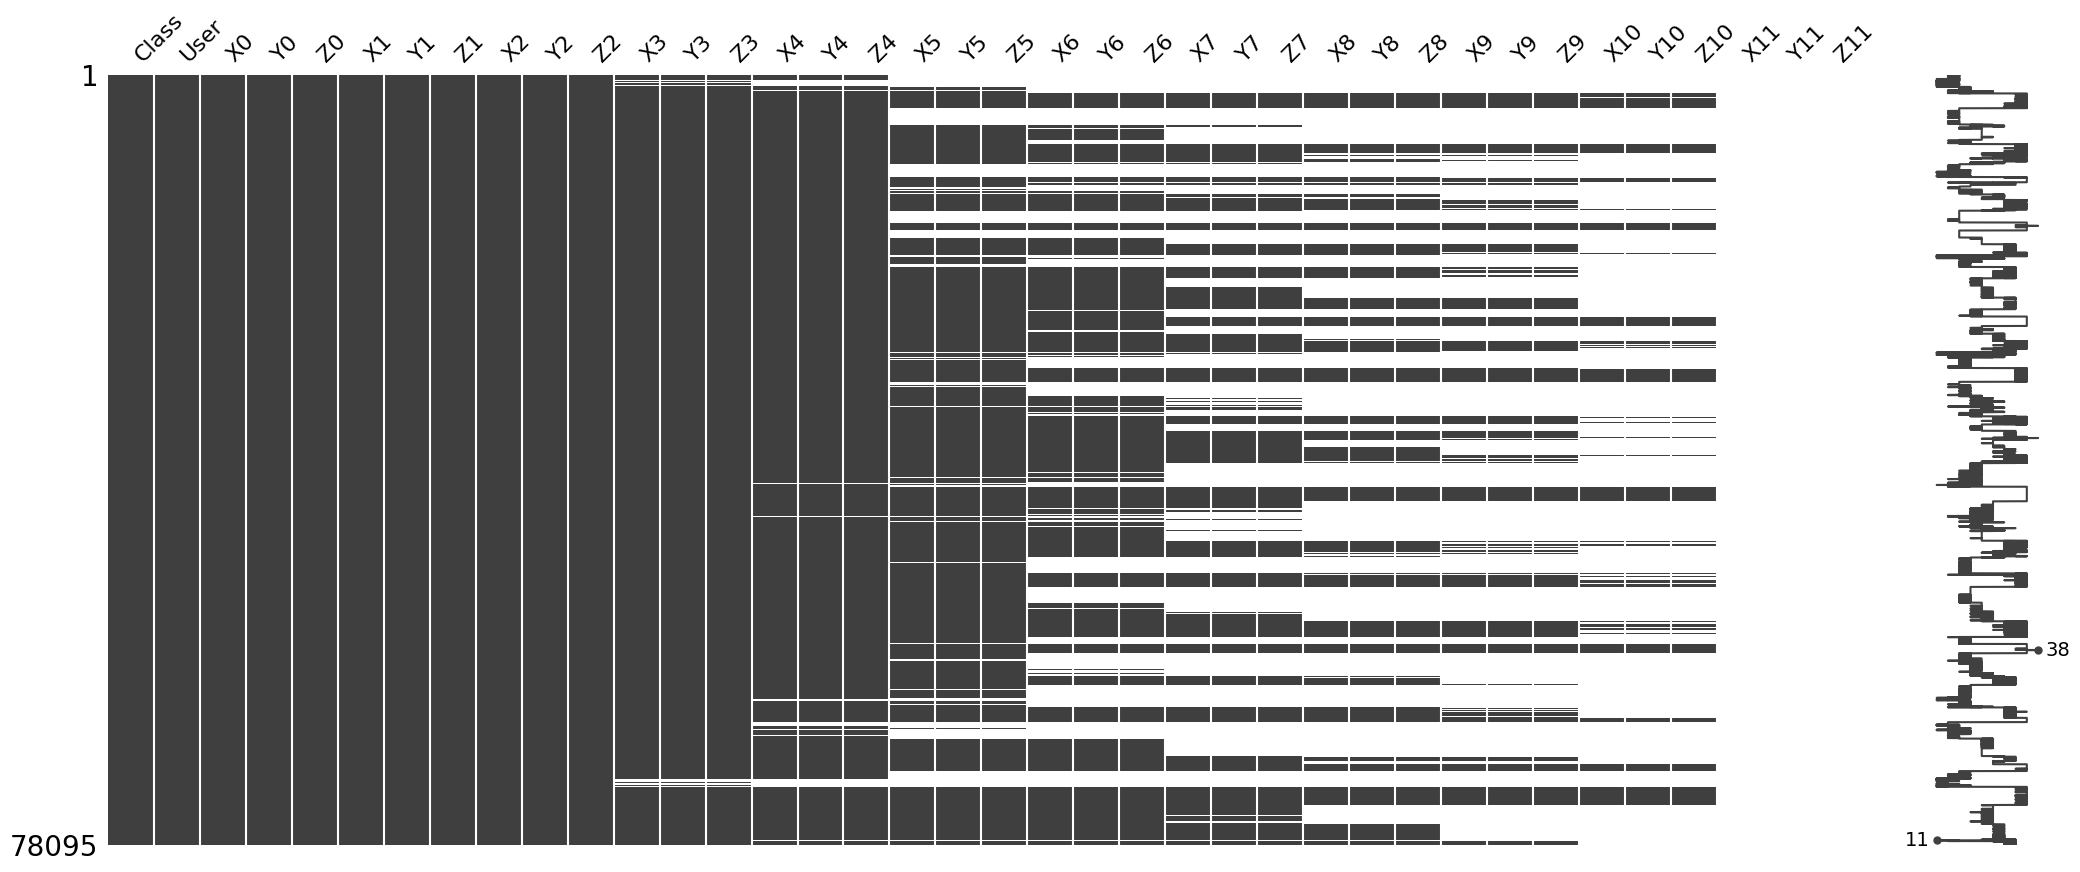

In [8]:
msno.matrix(postures)

De aquí se puede apreciar que a los puntos con valores completos se les han asignado los indices inferiores mientras que los puntos que faltan se han dejado con indices de valor superior. En la descripción del dataset se menciona que esto se hizo por comodidad a la hora de trabajar con ellos o tratarlos. Para nuestro problema, como solamente se quiere determinar a qué marcador pertenece cada punto, en principio no deberían molestarnos que un registro tenga valores perdidos, ya que esos marcadores no están presentes en la imagen capturada siquiera. Aún así los algoritmos de clustering que se busca aplicar no admiten valores perdidos, por lo que se ha optado por eliminar los puntos que faltan sin necesariamente eliminar la instancia entera; más adelante se explicará como se ha realizado esta operación.

#### Análisis gráfico univariante

En esta sección se pretende estudiar más a fondo las variables de las que se disponen con un enfoque gráfico. Comenzaremos por ver la cantidad de instancias que hay por clase de postura.

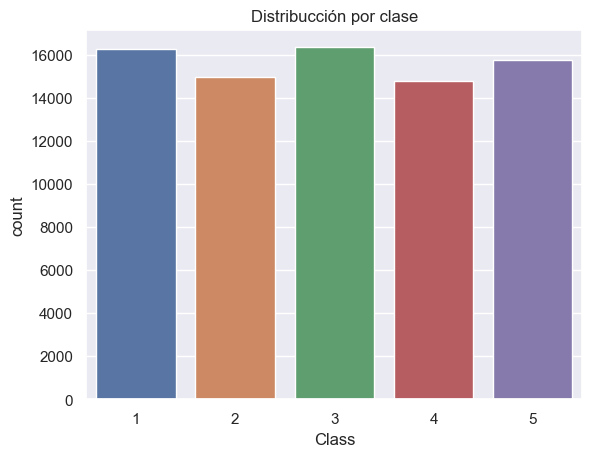

In [9]:
sns.set_theme()
sns.countplot(x='Class', data=postures).set(title='Distribucción por clase')
plt.show()

Hay cierdas diferencias, pero dentro de lo que cabe no hay clases muy desequilibradas.

Si representamos la cantidad de instancias por usuario:

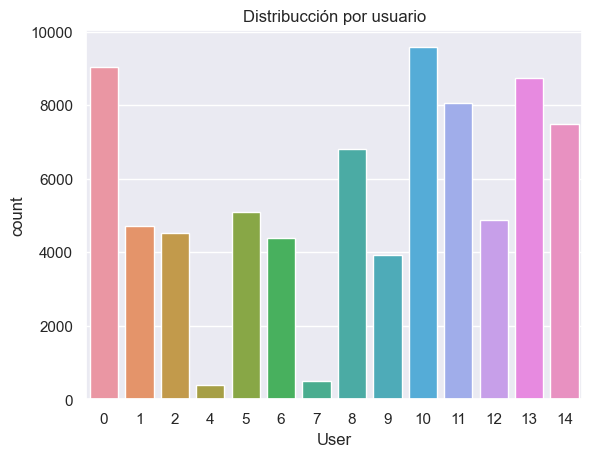

In [10]:
sns.countplot(x='User', data=postures).set(title='Distribucción por usuario')
plt.show()

Se pueden apreciar que las distintas categorías de esta variable están muy desequilibradas, siendo el usuario 4 y el 7 los menos representativos. 

Para las variables numéricas, puede que no tenga tanto sentido hacer un análisis por el problema ya descrito, ya que sus valores están desordenados y pueden corresponder a distintos marcadores. Aún así por curiosidad, vamos a representar la distribución de las coordenadas del primer punto y ver si se puede obtener más información sobre estas variables.

Para la variable $X_{0}$:

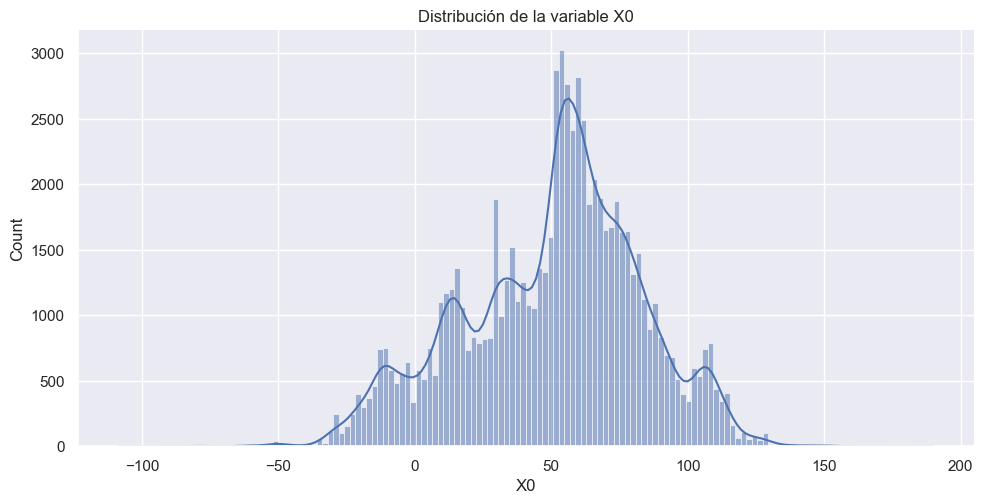

In [11]:
sns.displot(x='X0', data=postures, aspect=2, kde=True).set(title='Distribución de la variable X0')
plt.show()

Con la variable $Y_{0}$ se tiene:

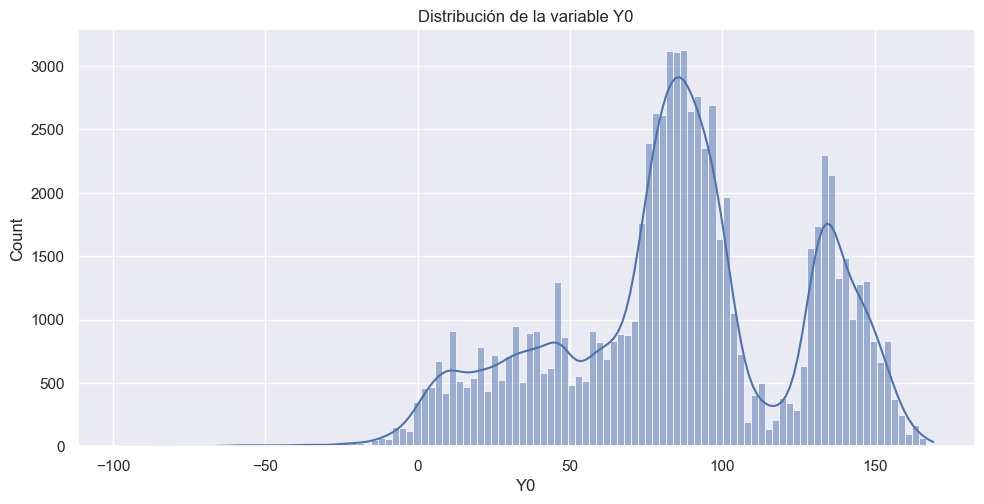

In [12]:
sns.displot(x='Y0', data=postures, aspect=2, kde=True).set(title='Distribución de la variable Y0')
plt.show()

Con $Z_{0}$:

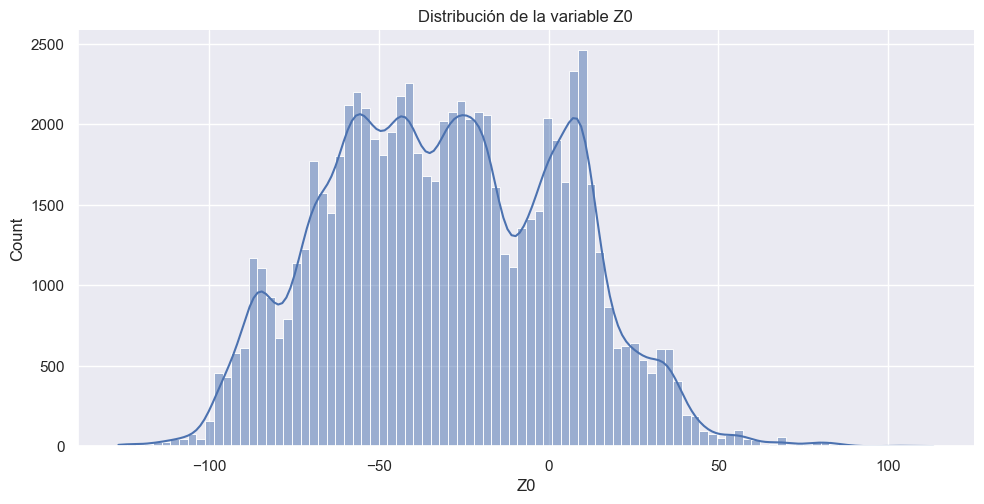

In [13]:
sns.displot(x='Z0', data=postures, aspect=2, kde=True).set(title='Distribución de la variable Z0')
plt.show()

Inmediatamente podemos comprobar que la mayoría de los valores de $X_{0}$ e $Y_{0}$ son positivos, mientras que para $Z_{0}$ ocurre lo contrario. También se pueden distinguir varios picos, sería interesante representar las distribuciones según la postura para comprobar si existe una relación.

#### Análisis gráfico multivariante

En este apartado se estudiarán algunas de las relaciones que hay entre las variables, y además se visualizarán los puntos de ciertas ionstancias en distintos planos, con el fin de hacer comprobaciones, obtener información sobre el problema y determinar que algoritmos de clustering podrían ser utilizados para clasificar los puntos en sus marcadores correctos.

Comenzaremos analizando la distribución de los datos por clase y por ususario:

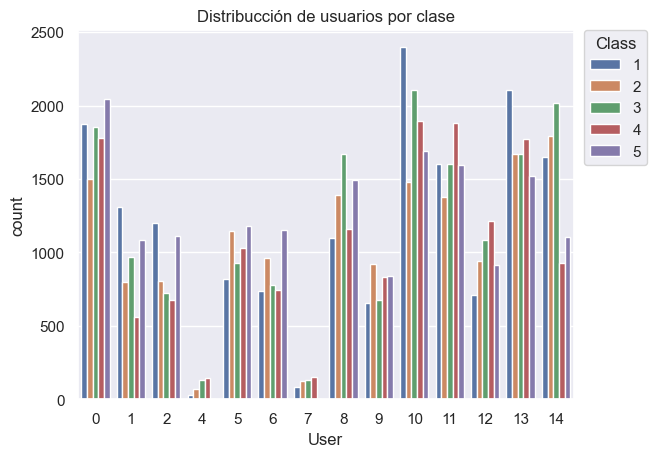

In [14]:
sns.countplot(x='User', data=postures, hue='Class').set(title='Distribucción de usuarios por clase')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Class')
plt.show()

Como se puede comprobar, los usuarios 4 y 7 no tienen instancias en la postura 5, y además tienen pocas observaciones de la postura 1.

Ahora se van a comprobar las distribuciones de las coordenadas del primer punto en función de la clase. Empezando por $X_{0}$:

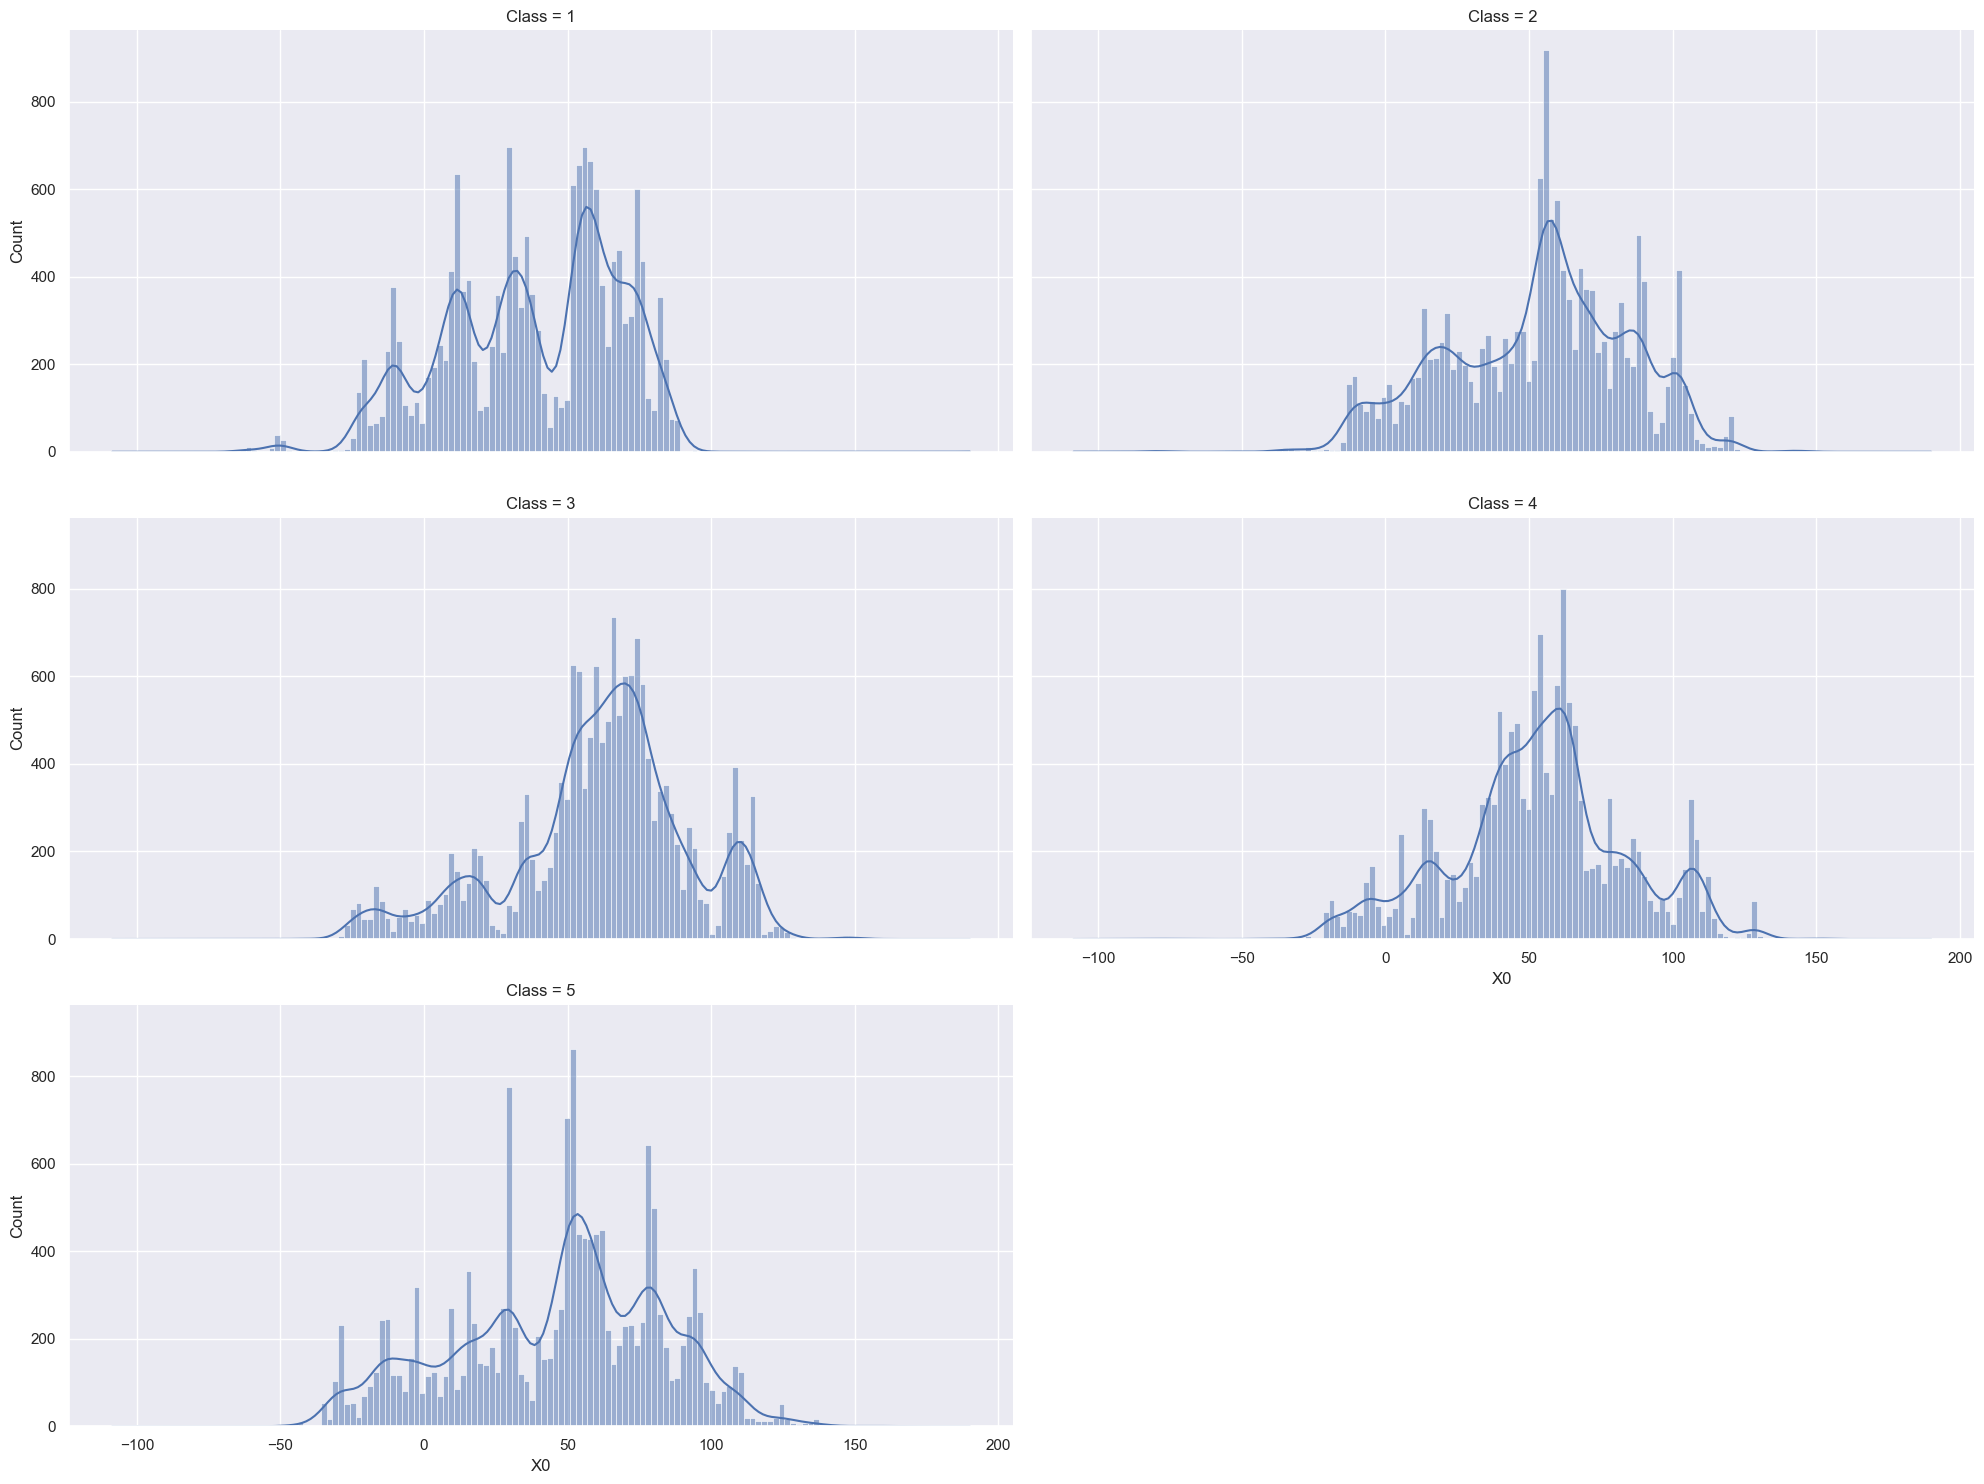

In [15]:
sns.displot(x='X0', data=postures, aspect=2, kde=True, col='Class',col_wrap=2)
plt.show()

Para $Y_{0}$:

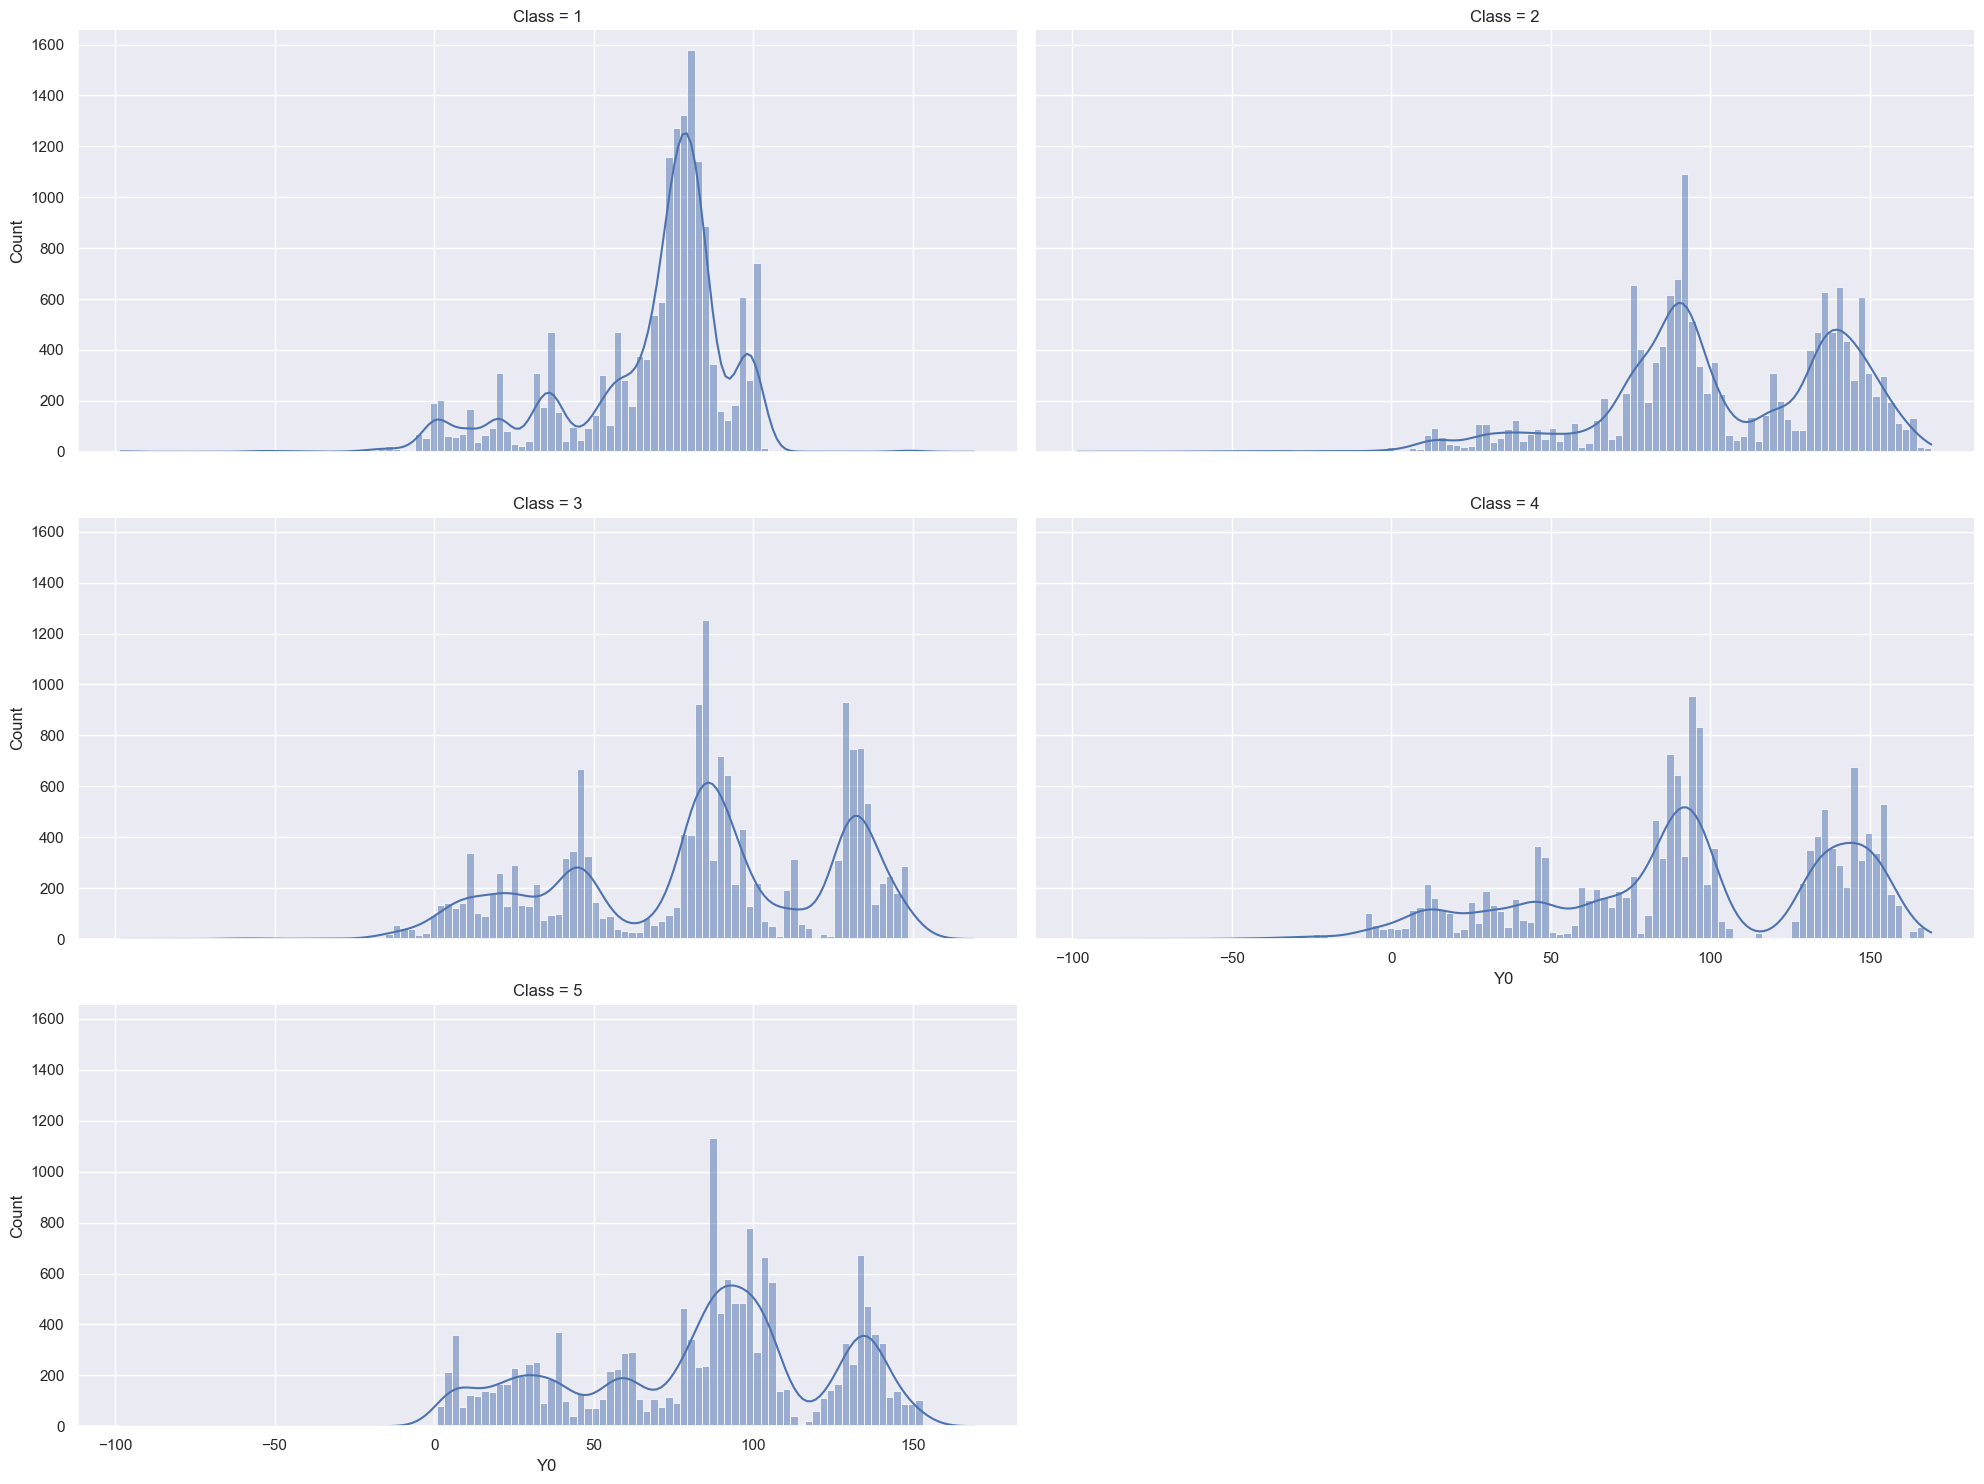

In [16]:
sns.displot(x='Y0', data=postures, aspect=2, kde=True, col='Class',col_wrap=2)
plt.show()

Y para $Z_{0}$:

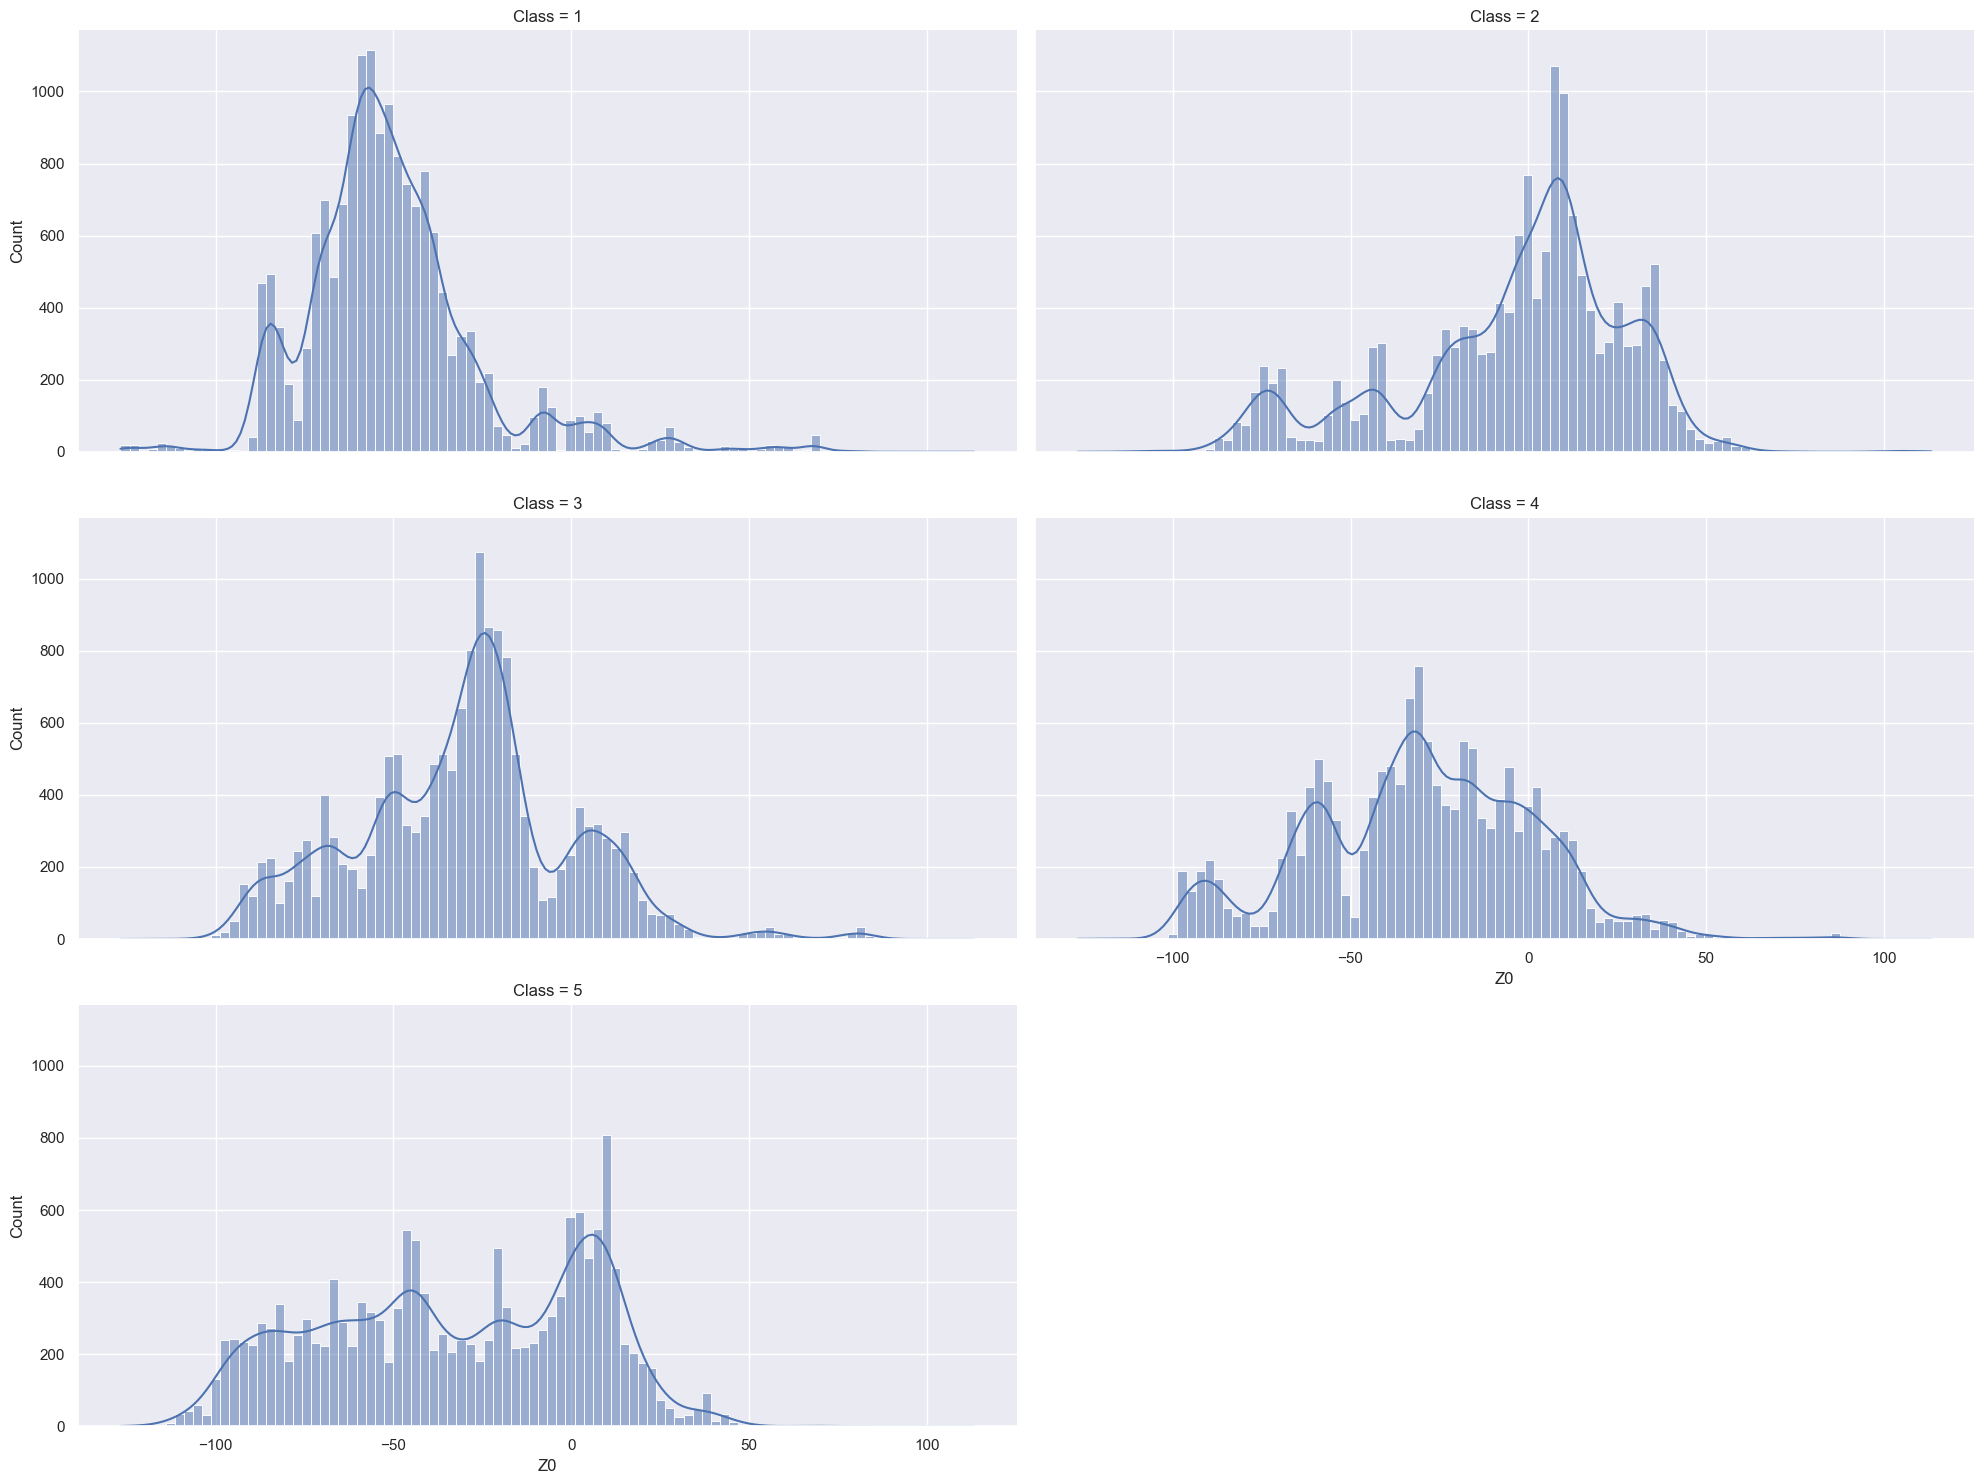

In [17]:
sns.displot(x='Z0', data=postures, aspect=2, kde=True, col='Class',col_wrap=2)
plt.show()

A primera vista hay diferencias en las distribuciones de las coordenadas según la clase, si nos fijamos en las gráficas de $X_{0}$ para la clase 1 y la clase 2 se puede distinguir en la distribución donde se encuentran los marcadores. Por ejemplo en la clase 1 el pico más grande encontrado a la derecha corresponde con los trews puntos que forman el pulgar, y el resto de picos que se pueden apreciar corresponden al marcador de cada dedo que se encuentra en la articulación. Esto se podrá visualizar mejor en lso siguientes gráficos cuando se representen los puntos en los distintos planos.

Debido al formato del dataset donde las coordenadas para cada punto están puestas como variable se ha optado por crear una función propia para representar los puntos de una o varias observaciones.

In [18]:
def visualize2D(data, instance, coord1, coord2, npoints):
    # Diccionario con las posiciones de las coordenadas
    coord_dict={'X':2,'Y':3,'Z':4}
    # Se establecen los límites con la primera instancia seleccionada
    plt.ylim(min(data.iloc[instance[0], coord_dict[coord2]::3])-20, max(data.iloc[instance[0], coord_dict[coord2]::3])+20)
    plt.xlim(min(data.iloc[instance[0], coord_dict[coord1]::3])-100, max(data.iloc[instance[0], coord_dict[coord1]::3])+100)
    # Se representa cada instancia
    for i in instance:
        plt.scatter(data.iloc[i, coord_dict[coord1]::3], data.iloc[i, coord_dict[coord2]::3],
                    c=range(npoints), cmap='rainbow')

    plt.colorbar()    
    plt.show()

Ahora podemos representar una de las observaciones en los diferentes planos, para ello se ha seleccionado una instancia donde todos los once puntos son visibles, por lo que tiene que ser una observación de la postura 2. 

In [19]:
postures.loc[1873]

Class      2.000000
User       0.000000
X0        63.554969
Y0        98.490988
Z0        11.165920
X1        49.159831
Y1       154.330730
Z1        32.004168
X2        92.793124
Y2       137.143202
Z2         1.064904
X3        80.854870
Y3        93.689656
Z3        -5.062411
X4        95.207049
Y4        73.672282
Z4       -74.307346
X5        58.421362
Y5        27.499634
Z5       -71.713081
X6        12.660462
Y6        95.077144
Z6        29.664434
X7        84.110115
Y7       151.545456
Z7        16.891147
X8        79.185592
Y8        54.753463
Z8       -72.462285
X9        20.730100
Y9       132.858512
Z9        35.501287
X10       35.490656
Y10       99.725676
Z10       22.690186
X11             NaN
Y11             NaN
Z11             NaN
Name: 1873, dtype: float64

Esta instancia es de la clase dos del primer usuario, y además tiene los once primeros puntos. Si se representan las coordenadas X contra Y: 

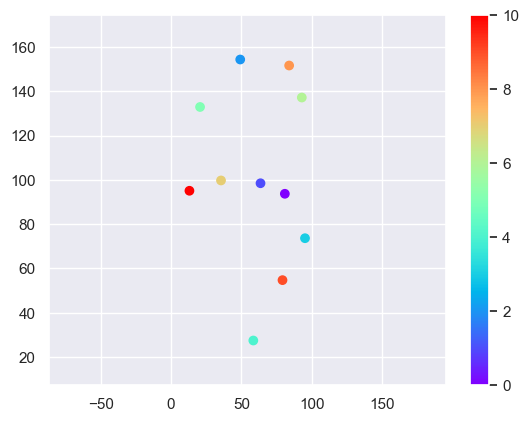

In [20]:
visualize2D(postures,[1873], 'X', 'Y', 12)

Se llega a distinguir la forma de una mano, con los tres puntos de menor valor en Y formando el pulgar, y cada par de puntos restantes, un dedo.

Se puede representrar esa misma instancia con las coordenadas X contra Z, o también Y contra Z

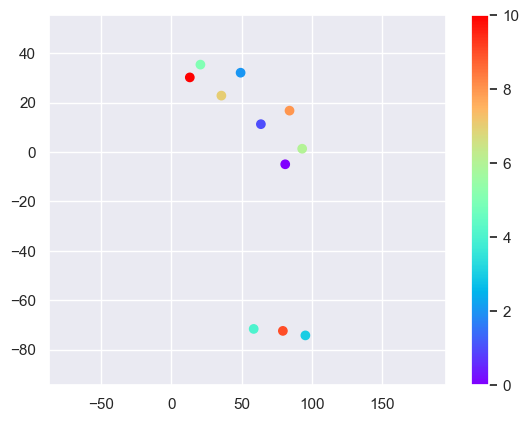

In [21]:
visualize2D(postures,[1873], 'X', 'Z', 12)

Se puede interpretar esta vista como si mirásemos la mano desde la muñeca, además se puede apreciar de que hay cierta rotación con respecto a la horizontal.

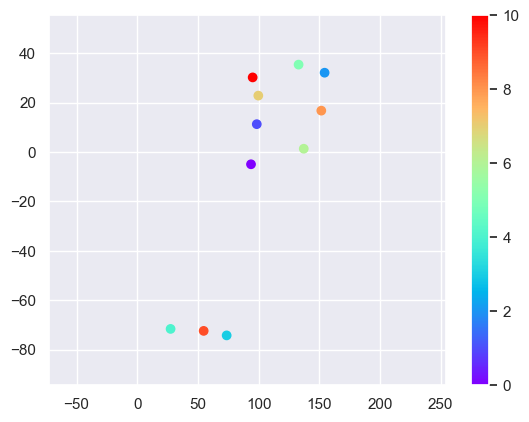

In [22]:
visualize2D(postures,[1873], 'Y', 'Z', 12)

Esta es la vista que tendríamos de nuestra mano izquierda si nos acercásemos la muñeca para mirar la hora.

Si nos damos cuenta, los colores de cada una de las tres figuras representadas coincide en el marcador que le corresponde, con la leyenda también se puede visualizar de qué punto se trata. Ahora sería interesante representar una instancia de cada postura para ver los marcadores que son visibles. Todas serán del primer usuario y de las coordenadas X e Y, ya que parece ser más fácil de distinguir. Empezando por la primera postura:

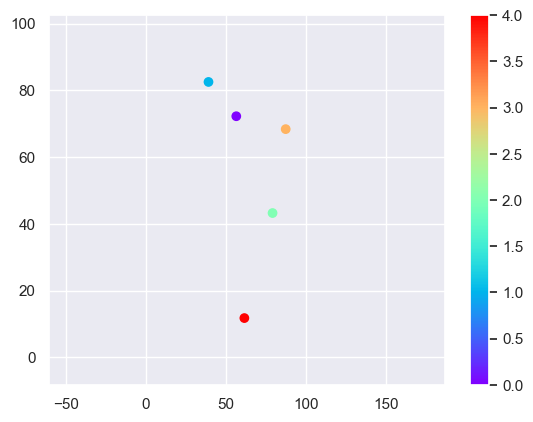

In [23]:
visualize2D(postures,[1], 'X', 'Y', 12)

La segunda postura, que ya hemos visto:

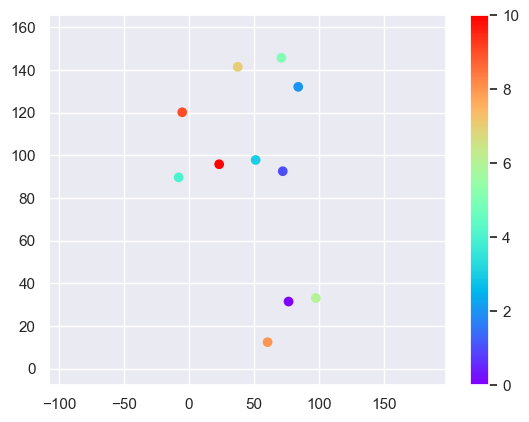

In [24]:
visualize2D(postures,[3000], 'X', 'Y', 12)

En la tercera postura:

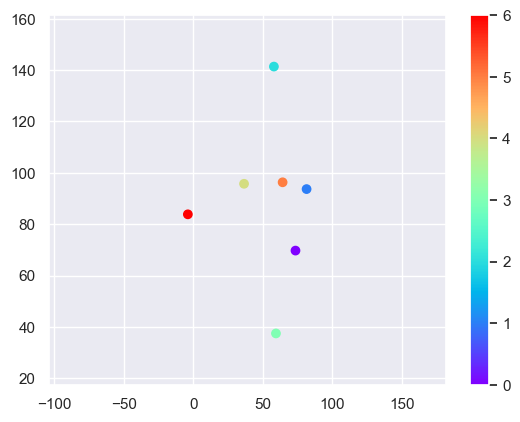

In [25]:
visualize2D(postures,[5028],'X', 'Y', 12)

En la cuarta psotura se tiene:

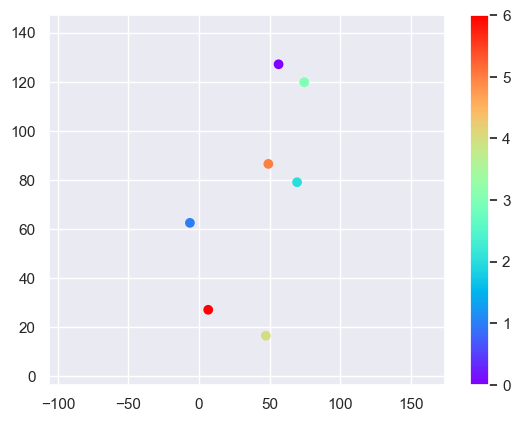

In [26]:
visualize2D(postures,[5241],'X', 'Y', 12)

Y por último, la quinta:

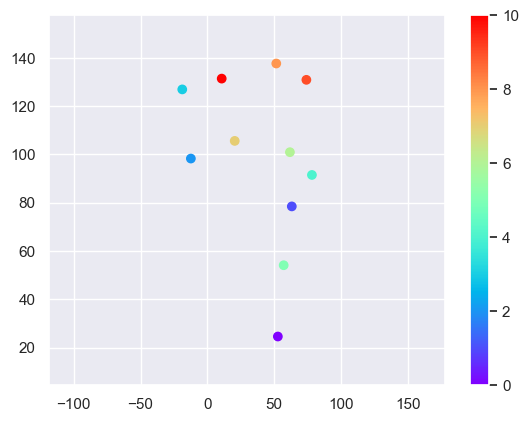

In [27]:
visualize2D(postures,[7008],'X', 'Y', 12)

Evidentemente la distribución de los marcadores es diferente según la postura que adopte la mano. Ahora sería interesante comprobar si los puntos están desordenados para cada instancia. Para ello, utilizaremos la segunda postura representando dos instancias que estén seguidas. La primera será la que hemos representado antes:

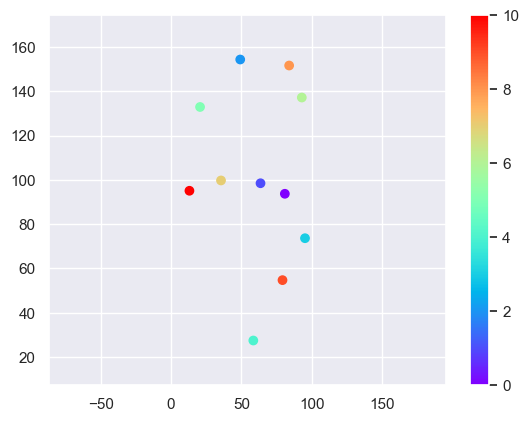

In [28]:
visualize2D(postures,[1873], 'X', 'Y', 12)

Si representamos la siguiente instancia, se tiene:

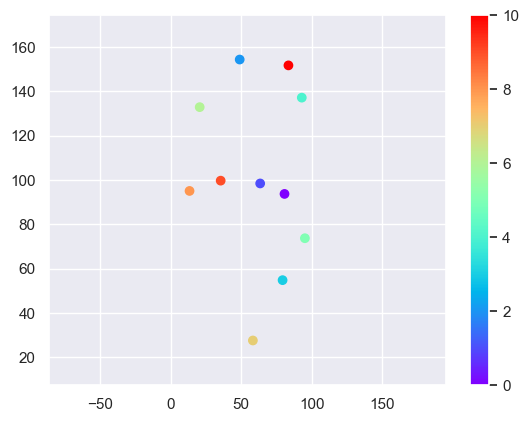

In [29]:
visualize2D(postures,[1874], 'X', 'Y', 12)

Como podemos comprobar el color de algunos de los puntos coincide en el mismo marcador, pero otros no. Esto quiere decir que los indices de los puntos no coinciden siempre en el mismo marcador, por lo que confirmamos que efectivamente los puntos están desordenados.

También se mencionó anteriormente que se estudiarían los casos donde el duodécimo punto es no nulo. Para ello identificamos qué instancias cumplen con esa condición (recordamos que las coordenadas de este punto sólo tenían un valor en 32 instancias en todo el dataset).

In [30]:
postures[~postures['X11'].isna()].head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
15303,2,2,27.418588,148.216120,14.770587,49.129027,99.723134,0.883278,92.301344,43.900549,...,7.015468,100.841332,65.337892,-54.651373,77.932709,16.487276,-60.048174,16.113686,-42.471264,-3.140685
15304,2,2,99.817462,65.686670,-55.457478,57.653306,152.188853,6.644935,92.276726,43.845759,...,14.037669,-1.211737,88.672706,10.187398,16.482357,-42.641627,-2.050853,2.582169,127.945490,11.415229
36818,2,9,71.944991,135.565802,-27.782710,86.536958,66.145021,-39.206386,30.328132,102.824000,...,2.384311,16.416635,127.743800,-19.398255,6.713694,90.193203,-13.508942,84.104979,44.247865,-45.390036
36819,2,9,86.346749,66.590273,-38.629277,71.496851,90.724686,-28.165732,51.263880,99.415833,...,-12.430796,78.022520,15.748048,-54.007325,4.626282,26.219870,2.409990,84.350011,44.798182,-44.880864
36820,2,9,72.541023,91.001656,-26.329067,87.507036,67.629524,-36.272075,71.195968,135.058671,...,-54.063723,40.442153,154.436985,-6.757292,83.578826,44.363539,-45.550582,5.494588,26.766967,3.806395


Si visualizamos una de ellas:

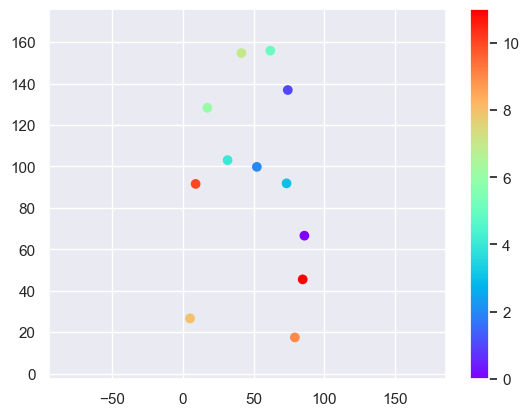

In [31]:
visualize2D(postures,[36820], 'X', 'Y', 12)

Como se puede observar aparece un punto en la muñeca donde no hay ningún marcador, por lo que este punto puede haber sido generado por error debido a los artefactos en la imagen mencionados anteriormente. Se ha obtado por eliminar este punto del dataframe eliminando las tres coordenadas, para ello se deben eliminar las 32 instancias también, ya que si eliminamos solamente el último punto, para esas instancias puede que se elimine el punto de otro marcador y no el erróneo.

In [32]:
# Quitamos instancias que tengan las 12 variables
postures = postures.drop(axis=0, index=postures[~postures['X11'].isna()].index)
postures.shape

(78064, 38)

In [33]:
# Dropeamos las tres útimas variables 
postures=postures.drop(columns=['X11','Y11','Z11'])

In [34]:
postures.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para acabar el análisis multivariante queda representar un gran número de instancias seguidas para determinar como se podría afrontar mejor el problema y qué algoritmo de clustering podría ser interesante aplicar. Para ello se representarán las posturas 2 y 3 del primer usuario y del usuario número 7 (que tiene pocas instancias) con la vista de las coordenadas X e Y.

Empezando por el usuario 0, buscamos los índices de las posturas 2 y 3, y las representamos:

In [35]:
postures[(postures['Class']==2) & (postures['User']==0)]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
1873,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,16.891147,79.185592,54.753463,-72.462285,20.730100,132.858512,35.501287,35.490656,99.725676,22.690186
1874,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,22.802243,83.936993,151.633126,16.718403,79.206045,54.736681,-72.428160,13.023862,95.083306,30.173558
1875,2,0,80.775150,93.705283,-5.090904,63.479609,98.429524,11.161413,48.924111,154.340338,...,-71.888449,13.286942,95.053108,30.491436,35.414671,99.693011,22.727090,83.566302,151.704826,16.334552
1876,2,0,80.618164,93.781461,-5.012812,63.213130,98.462919,11.045095,48.777435,154.327283,...,-73.894505,20.628186,132.787591,35.836072,58.206613,27.734229,-71.966263,13.291561,95.017228,30.658062
1877,2,0,79.870413,93.921192,-5.628231,79.239570,55.197852,-72.374008,48.446947,154.215388,...,-72.379748,20.453203,132.633282,36.134339,93.118826,137.151230,2.451086,12.963087,94.882413,30.552576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,2,0,52.306259,15.978526,-78.408173,64.150023,38.283252,-92.553815,37.234794,140.719570,...,51.574960,20.631320,96.780967,15.492278,79.711961,44.638186,-101.797289,76.164049,137.490642,1.688374
3370,2,0,66.051988,39.018661,-90.246335,36.521489,139.940957,48.975496,76.508176,137.033503,...,-13.987881,46.696729,101.459977,3.583711,-3.434032,113.637661,51.634400,81.988694,45.209454,-98.821187
3371,2,0,67.362811,38.598386,-88.680541,76.910655,136.713584,6.161920,55.037129,16.078205,...,27.804267,-2.953757,112.986230,52.471293,66.296156,97.270160,-12.916579,21.325430,95.582595,18.579046
3372,2,0,63.723288,37.778625,-92.157394,52.608227,15.071338,-76.694588,46.430638,101.701597,...,50.131596,65.505551,97.318780,-16.211570,63.296555,151.942720,19.941316,-8.305558,86.105318,25.893018


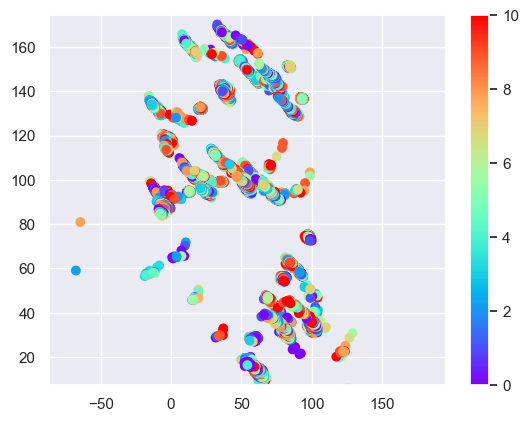

In [36]:
visualize2D(postures,range(1873,3370), 'X', 'Y', 11)

In [37]:
postures[(postures['Class']==3) & (postures['User']==0)]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
3374,3,0,58.638966,4.894219,-76.641039,53.000355,135.415120,-41.637286,75.431462,20.781456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3375,3,0,58.425639,4.941919,-76.806993,75.211122,20.806249,-87.818424,53.251095,135.214529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3376,3,0,58.387273,5.042364,-76.849587,58.832108,90.935895,-35.460120,75.197819,20.959359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3377,3,0,58.608281,4.881092,-76.709324,59.053447,90.824538,-35.314756,75.202805,20.878766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3378,3,0,58.888117,4.809086,-76.479123,75.467360,20.730494,-87.627401,53.507440,135.088198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,3,0,74.356783,23.955298,34.029076,35.726967,99.713003,79.668007,17.727705,76.887870,...,79.465143,67.23463,40.700556,44.07148,NaN,NaN,NaN,NaN,NaN,NaN
5221,3,0,17.954768,77.003855,84.101638,73.935585,25.492683,32.138286,61.337160,65.013108,...,48.259751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5222,3,0,73.950375,26.156156,31.066242,-2.645504,49.481631,79.133775,61.415591,66.313344,...,47.393365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5223,3,0,73.877917,26.801118,30.175558,61.390573,66.883717,53.167657,-2.155563,46.886149,...,9.980594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


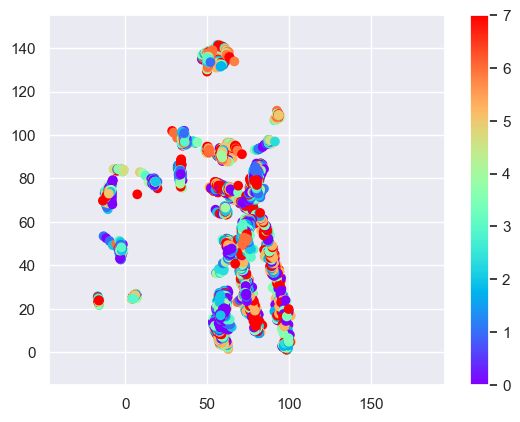

In [38]:
visualize2D(postures,range(3374,5224), 'X', 'Y', 11)

Se puede comprobar que hay una noción temporal, que como se había dicho anteriormente, las distintas instancias corresponden a fotográmas del sistema de captura. Esto es evidente debido al desplazamiento que se aprecia de los marcadores. Si se visualiza el usuario 7 se obtiene:

In [39]:
postures[(postures['Class']==2) & (postures['User']==7)]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
28224,2,7,100.629441,18.855038,-52.673145,59.735647,120.916489,-0.669718,21.452139,107.441101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28225,2,7,-2.565424,67.217987,19.303755,106.318817,27.990156,-30.674818,78.521091,112.391965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28226,2,7,74.239856,54.171994,6.746323,92.717752,96.318436,23.565233,-2.344610,67.387841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28227,2,7,85.508778,-9.719544,-38.426534,98.303685,15.438016,-20.038805,73.706108,110.002101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28228,2,7,-5.632354,69.787517,14.823781,30.653189,69.024596,17.184697,107.758518,27.612316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28343,2,7,80.594502,101.420580,-34.448168,66.909559,54.646019,-23.535417,53.335060,122.292181,...,-15.459109,88.531282,-18.461563,-45.715546,NaN,NaN,NaN,NaN,NaN,NaN
28344,2,7,83.976353,-18.366727,-48.366377,72.645621,102.759535,-45.613384,98.729515,2.026604,...,-35.471557,13.176316,108.676184,-20.427941,NaN,NaN,NaN,NaN,NaN,NaN
28345,2,7,106.348180,15.151019,-41.042754,55.042646,122.695833,10.902525,66.309779,60.778544,...,-6.066650,-5.411699,74.879924,7.087211,NaN,NaN,NaN,NaN,NaN,NaN
28346,2,7,53.834693,122.210328,-8.513793,72.279442,119.562114,-12.336040,103.365200,10.196753,...,-2.786173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


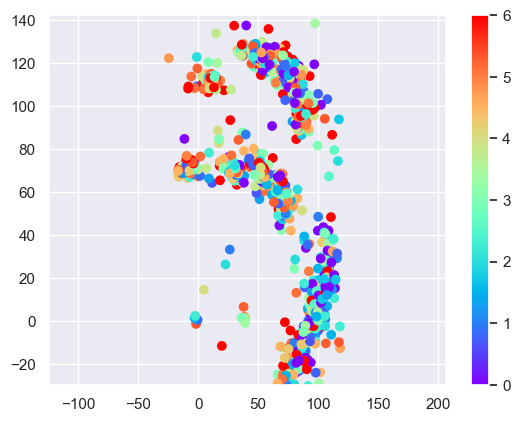

In [40]:
visualize2D(postures,range(28224,28347), 'X', 'Y', 11)

In [41]:
postures[(postures['Class']==3) & (postures['User']==7)]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
28348,3,7,79.961780,115.990855,3.340649,39.748121,86.760216,-19.947534,22.796966,26.308624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28349,3,7,68.321612,67.732989,8.487527,26.404594,33.217544,-85.004191,80.916124,28.613721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28350,3,7,109.650805,34.480865,-18.520733,93.790912,16.367197,-29.029609,-8.366439,78.301091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28351,3,7,-7.839768,66.064434,-43.960417,69.084591,62.440383,-4.960645,95.477488,-11.774171,...,-43.877962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28352,3,7,60.412071,52.597704,-44.785769,69.036929,98.074246,-65.500408,25.366042,50.873785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28477,3,7,75.899271,-15.488727,-46.333695,85.492812,42.331865,-34.541291,80.236032,17.370149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28478,3,7,80.119329,16.717962,-36.648967,74.114283,-14.612751,-47.738157,86.824238,41.148468,...,-59.947079,-6.575715,22.084706,-51.560884,NaN,NaN,NaN,NaN,NaN,NaN
28479,3,7,38.335748,65.038292,-56.345959,73.089513,-23.861948,-50.112510,93.607158,31.929546,...,-64.325383,-8.105089,55.097620,-57.337262,NaN,NaN,NaN,NaN,NaN,NaN
28480,3,7,24.960770,63.940047,-52.870542,83.077708,9.936848,-37.056525,-2.432031,59.740248,...,-29.203959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


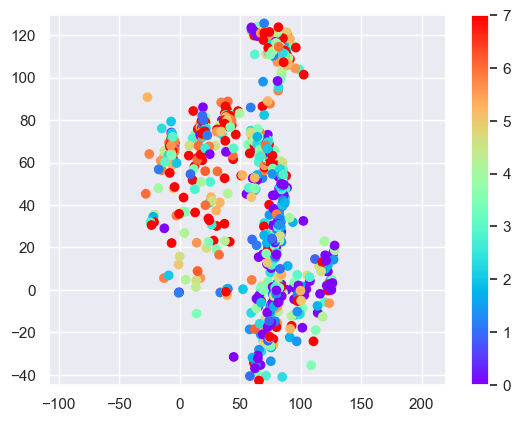

In [42]:
visualize2D(postures,range(28348,28481), 'X', 'Y', 11)

Para ambos usuarios se pueden aprecias agrupaciones de puntos con formas arbitrarias, lo que nos podría llevar a pensar que un algoritmo de clustering que se base en hiperesferas no daría buenos resultados. En cambio, al tener cierta noción de desplazamiento en el tiempo y la forma que tienen los grupos de puntos, parece que un algoritmo basado en densidad podría ser el indicado para el problema propuesto. Tambiuén cabe destacar en el las gráficas representadas también se pueden distinguir ciertos puntos extraños debido al artefacto que se produce en los que un algoritmo basado en densidad no tendría problema en descartarlos como outliers.

## Metodología

Como se ha comprobado, el número de puntos visibles dependerá de la postura y del usuario, por lo que se ha optado por seguir una estrategia de "divide y vencerás". No sólo simplificando el problema en varios casos parecidos, sino dividiendo el dataset en partes más pequeñas ayudando al algoritmo basado en densidad a procesar un menor número de instancias. La manera de hacer la división vendrá explicada en el apartado de experimentación.

A la misma vez que se efectúa la división, se aplicará la normalización de las variables; y por medio de una función propia, se pretende cambiar el formato del dataframe. Esto es necesario, ya que para aplicar los algoritmos de clustering queremos hacer uso solamente de las tres coordenadas de cada punto y no calcular las distancias entre coordenadas de distintos puntos. Es decir, si ahora mismo se tiene un dataframe cuyas variables son: $X_{i}$, $Y_{i}$ y $Z_{i}$, con i siendo el índice del punto; se quiere transformar a un dataframe que tenga las variables: punto, X, Y y Z, donde la variable punto indica el índice del punto y las otras tres columnas son sus coordenadas.

El primer algoritmo de clustering que se aplicará como primera toma de contacto, será KMeans. Con el que se hará un estudio para dos casos de los parámetros más óptimos y se extrapolarán las nociones adquiridas para aplicar el algoritmo al resto de los casos de forma óptima. Se tomarán diferentes medidas de calidad de los clusters formados para determinar la validez del algoritmo para este problema.

El siguiente algoritmo que se utilizará será DBSCAN, ya que como se ha mencionado en el análisis exploratorio de los datos, parece que la estructura de los puntos se podría formar de manera óptima utilizando un algoritmo de clustering basado en densidad. Los parámetros se ajustarán de forma manual para dos de los casos como primera aproximación, y después se intentarán  ajustar de manera automática para el resto de casos. Se tomarán medidas de calidad de los clusters encontrados y se compararán con las obtenidas en el algoritmo de KMeans. Cabe destacar que se utilizará la distancia euclídea para ambos algoritmos debido a que se tratan de puntos en el espacio tridimensional.

Las medidas de calidad que se utilizarán son:
* Índice de Davies-Boulding: mide la similitud de cada clúster con el clúster más similar, es decir se calcula con el ratio de la distancia media dentro del clúster entre la del clúster más cercano.
* Silueta: se calcula utilizando la distancia media entre-clúster y la distancia media al clúster más cercano para cada ejemplo. Toma valores entre 1 y -1, siendo mejor cuanto mayor sea.

## Experimentación y discusión de resultados

Lo primero que se debe hacer es importar los paquetes que se requieren para la parte de experimentación.

In [43]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

### Formateo de datos y normalización

Como se ha mencionado, se pretende dividir el dataset por sus posturas, pero antes de eso se debe definir las funciones que realizan el redimensionamiento y la normalización.

La función de redimensionamiento consiste en una función que crea una lista para cada una de las tres coordenadas de cada punto. Por otro lado, sabiendo que se tienen once puntos, se crea la lista de puntos repitiendo los valores del 1 al 11. De forma parecida se crea la lista de las instancias, que sirve para referenciar cada punto a su instancia original por si se quisiera reconstruir el dataframe original. Finalmente, se crea el dataframe y se eliminan los valores perdidos, que en este caso sería tan fácil como eliminar las intancias que tengan valores perdidos.

In [44]:
def transform3D_df(df):
    Xlist = df.iloc[:,2::3].values.tolist()
    X = [value for list in Xlist for value in list]
    Ylist = df.iloc[:,3::3].values.tolist()
    Y = [value for list in Ylist for value in list]
    Zlist = df.iloc[:,4::3].values.tolist()
    Z = [value for list in Zlist for value in list]
    point = [p for i in range(df.shape[0]) for p in range(1,12)]
    instance = [i for i in range(df.shape[0]) for j in range(1,12)]
    transformed_df = pd.DataFrame(data=list(zip(instance,point,X,Y,Z)),columns=['instance','point','X','Y','Z'])
    return transformed_df.dropna()

Por otro lado se define una función para normalizar las variables. Esta función normaliza las coordenadas y luego reconstruye el dataframe con las variables de puntos e instancias.

In [45]:
def normalize(df):
    scaler = MinMaxScaler()
    scaler.fit(df.drop(columns=['point','instance']))
    results_norm = scaler.transform(df.drop(columns=['point','instance']))
    results_norm=np.c_[df.instance, df.point, results_norm]
    return pd.DataFrame(results_norm, index=df.index, 
                           columns=df.columns)

Por último se define la función que divide el dataframe y llama a las funciones de transformación y normalización. El método escogido para dividir el dataframe es crear un diccionario para cada postura cuyas llaves corresponderán a cada usuario y el valor asociado a cada llave será el dataframe que corresponde a ese usuario para esa postura.

In [46]:
def divide_df(df, column, keyname):
    df_dict = {}
    for value in df[column].unique():
        df_dict[keyname+str(value)]=normalize(transform3D_df(df[df[column]==value]))
    return df_dict

Una vez se tienen las funciones necesarias, se crean los diccionarios para cada una de las posturas:

In [47]:
postures_pos1 = divide_df(postures[postures['Class'] == 1], 'User', 'User')
postures_pos2 = divide_df(postures[postures['Class'] == 2], 'User', 'User')
postures_pos3 = divide_df(postures[postures['Class'] == 3], 'User', 'User')
postures_pos4 = divide_df(postures[postures['Class'] == 4], 'User', 'User')
postures_pos5 = divide_df(postures[postures['Class'] == 5], 'User', 'User')

Si ahora llamamos al diccionario correspondiente a la postura 1, se puede comprobar que la división, formateo y normalización de los datos se ha realizado exitósamente.

In [48]:
postures_pos1

{'User0':        instance  point         X         Y         Z
 0           0.0    1.0  0.518024  0.721175  0.393453
 1           0.0    2.0  0.598375  0.423848  0.357409
 2           0.0    3.0  0.455386  0.825878  0.447199
 3           0.0    4.0  0.627973  0.683066  0.353325
 4           0.0    5.0  0.535508  0.098031  0.364113
 ...         ...    ...       ...       ...       ...
 20581    1871.0    1.0  0.525140  0.797280  0.420258
 20582    1871.0    2.0  0.601259  0.434707  0.355635
 20583    1871.0    3.0  0.641313  0.675911  0.346874
 20584    1871.0    4.0  0.449583  0.889634  0.461621
 20585    1871.0    5.0  0.530230  0.116868  0.359174
 
 [8998 rows x 5 columns],
 'User1':        instance  point         X         Y         Z
 0           0.0    1.0  0.592838  0.992906  0.528096
 1           0.0    2.0  0.354946  0.982292  0.656438
 2           0.0    3.0  0.888118  0.975031  0.400576
 3           0.0    4.0  0.098955  0.950542  0.809371
 4           0.0    5.0  0.972120  0

Con los datos listos, se puede comenzarel estudio correspondiente de los algoritmos de clústering.

### KMeans

Lo primero que se podría probar para este algoritmo como toma de contacto sería un estudio de la k óptima, aunque para este problema no sería necesario debido a que dependiendo de la postura, el número de clusters a formar queda determinado por el número de puntos que se necesiten agrupar; es decir, viene determinado por el número de marcadores que está asociado a la postura. Aún así, es interesante ver el proceso de formación de las agrupaciones.

Para el estudio seleccionaremos la primera postura escogiendo el usuario 0 por tener un gran número de instancias y el usuario 4 que es el que menos instancias tiene. También será necesario utilizar una función vista en clase para representar los clusters y sus centroides.

In [49]:
#Función vista en clase para visualizar los clústers
def mostrar(X, c=None, centroids=None,i=0,j=0):

    # Creamos la figura
    plt.figure(figsize=(10,8))

    # Pintamos los puntos
    plt.scatter(X.iloc[:, i], X.iloc[:, j], c=c, cmap='rainbow', s=60)

    # Pintamos los centroides si los hay 
    # ligero cambios con respecto a la función del notebook anterior
    if centroids is not None:
        plt.scatter(centroids[:,i], centroids[:,j], marker='*', c=range(centroids.shape[0]), s=500)

    # Mostramos la figura
    plt.show()

Ahora se van a comprobar distintos valores de k para el usuario 0:

k=1


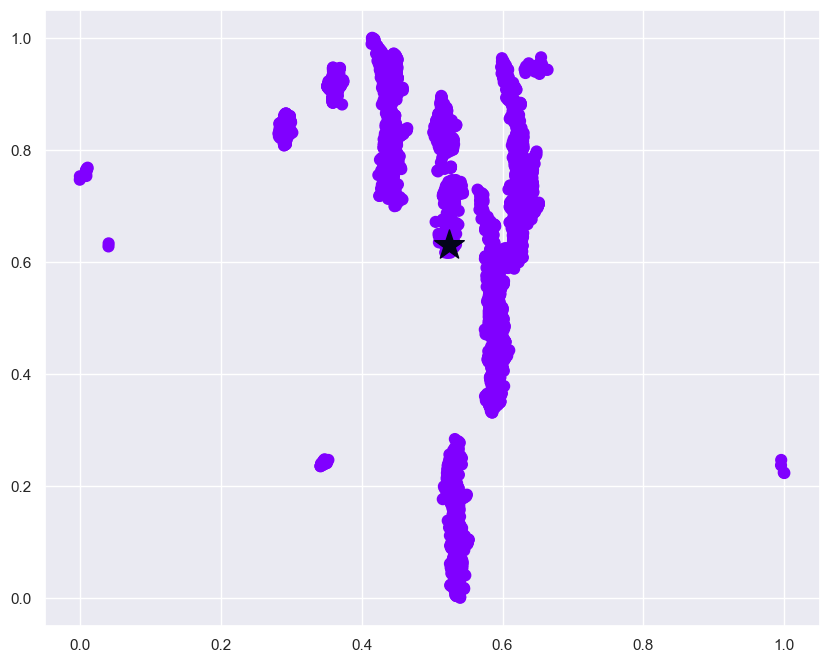

k=2


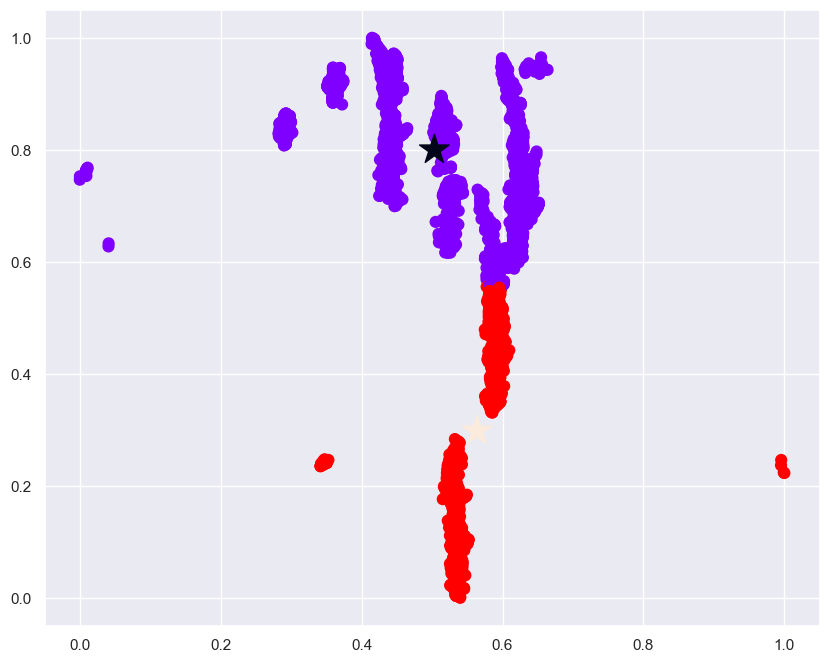

k=3


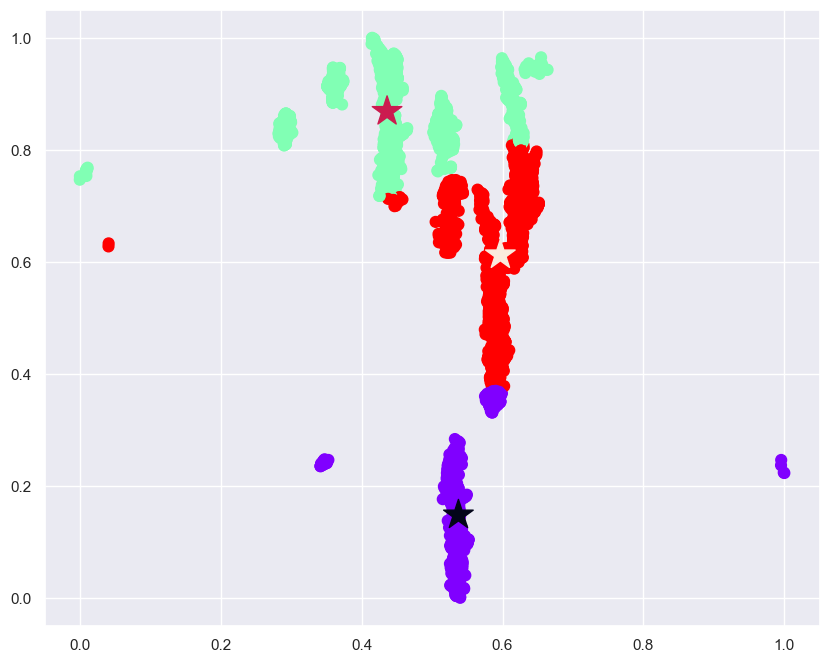

k=4


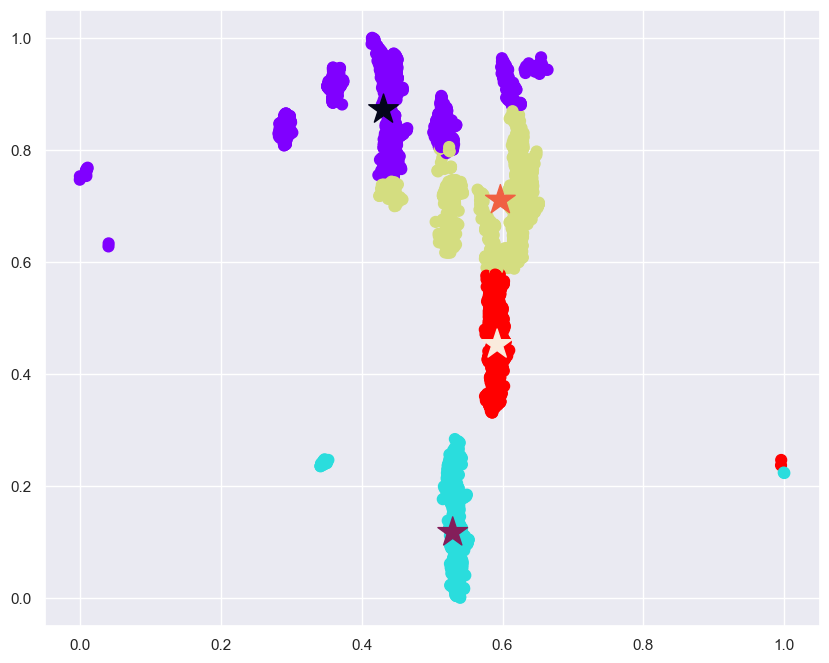

k=5


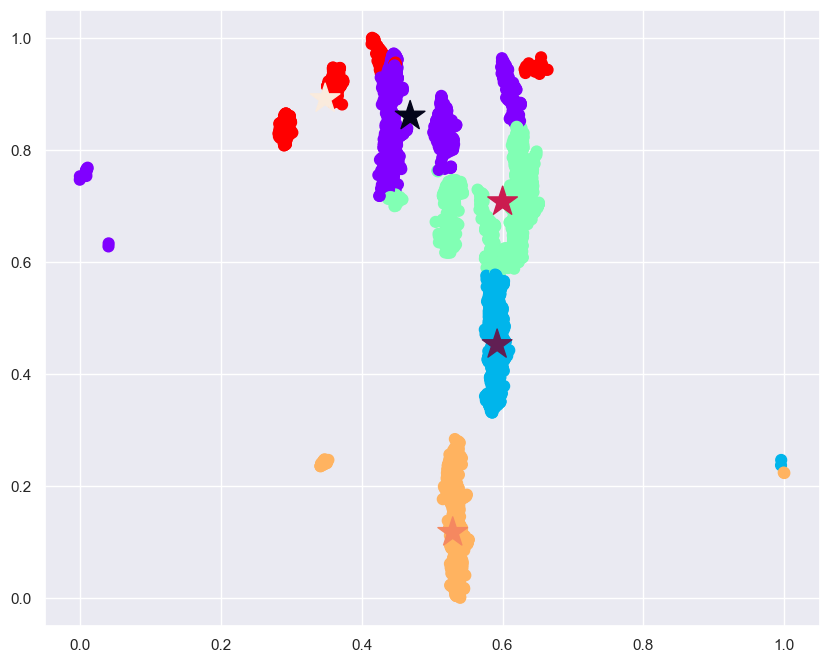

k=6


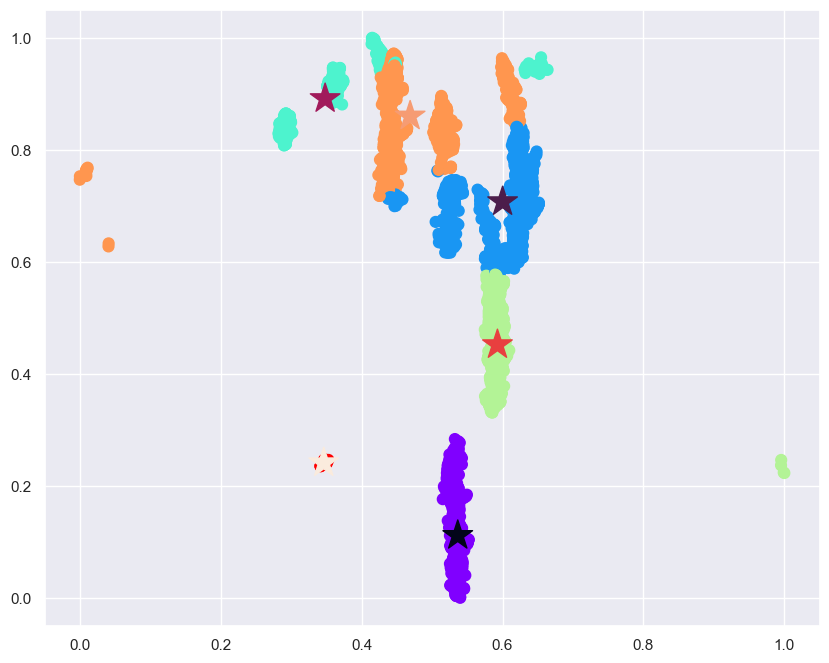

k=7


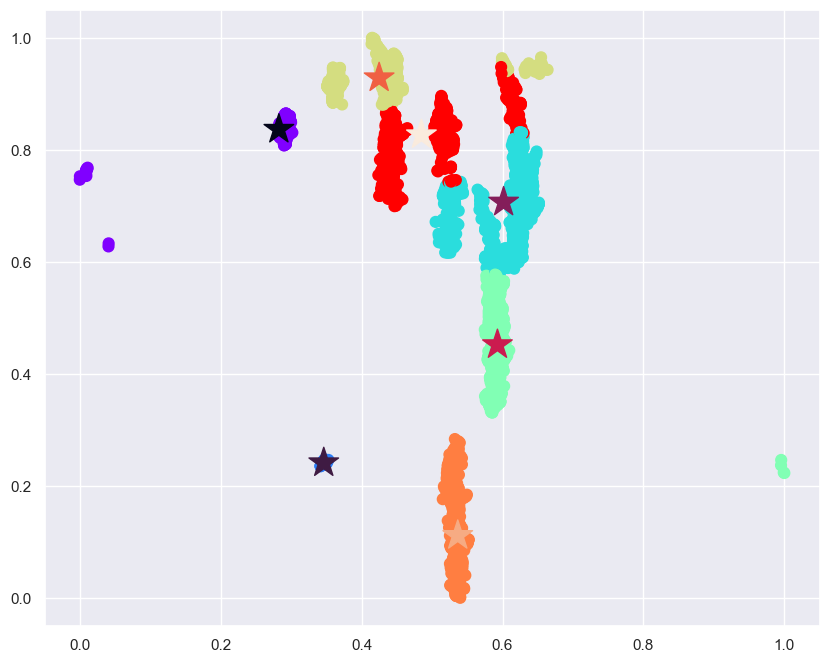

k=8


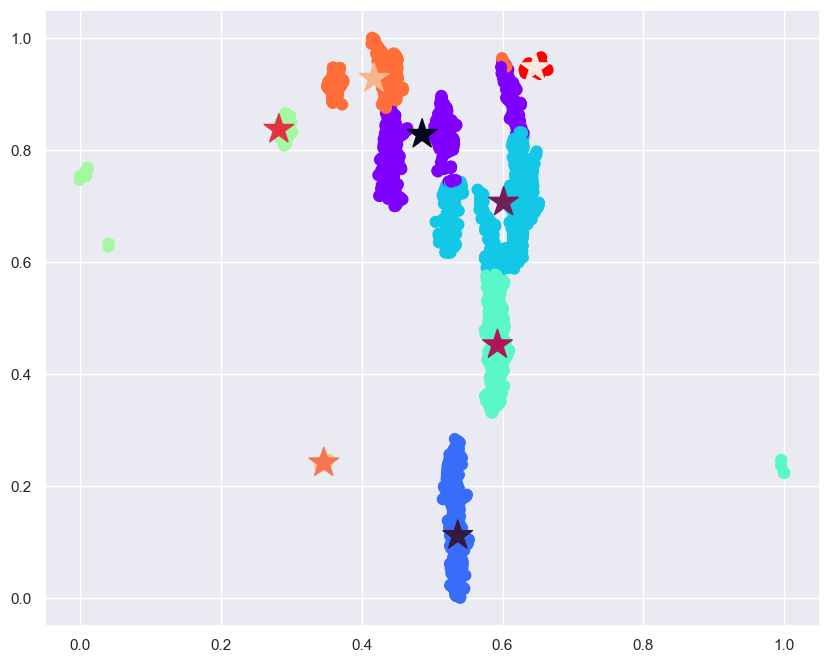

k=9


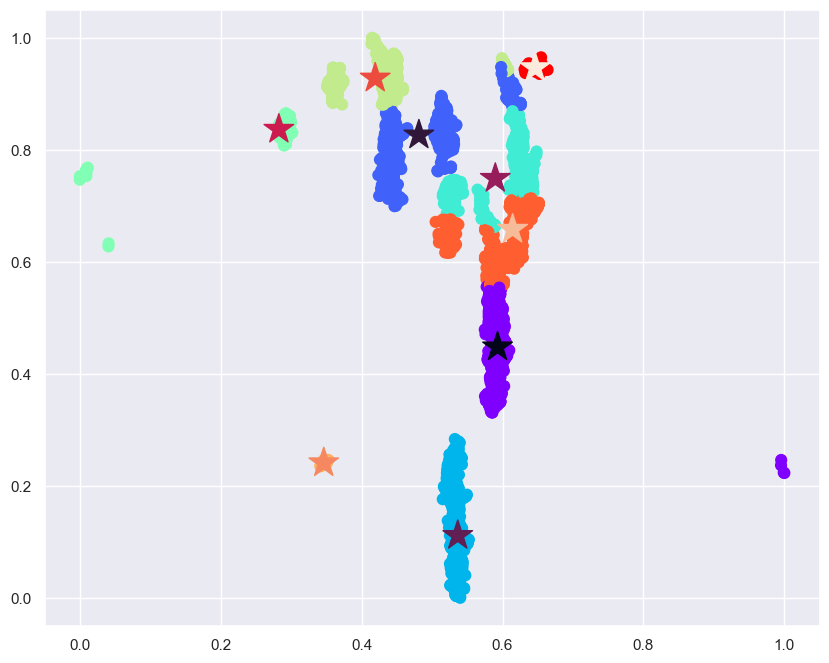

k=10


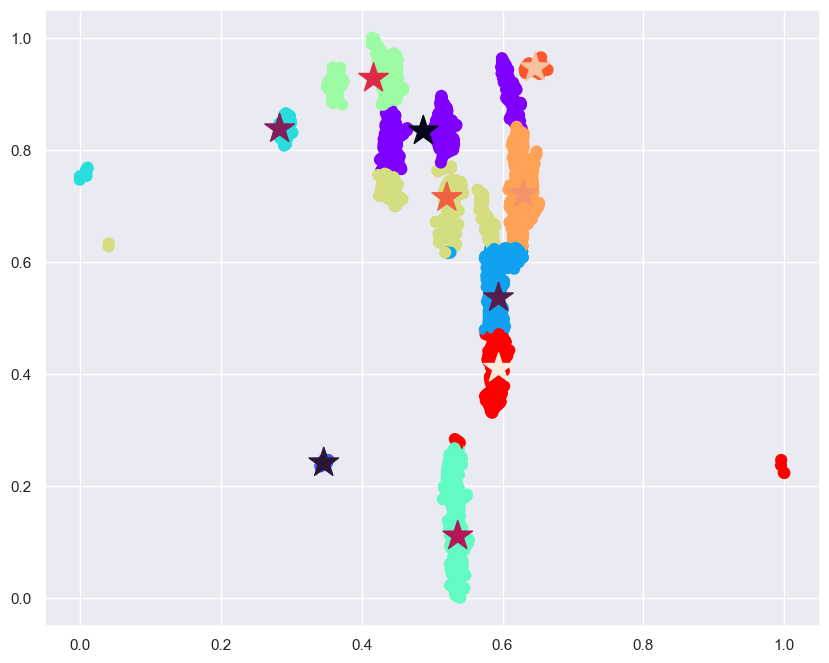

k=11


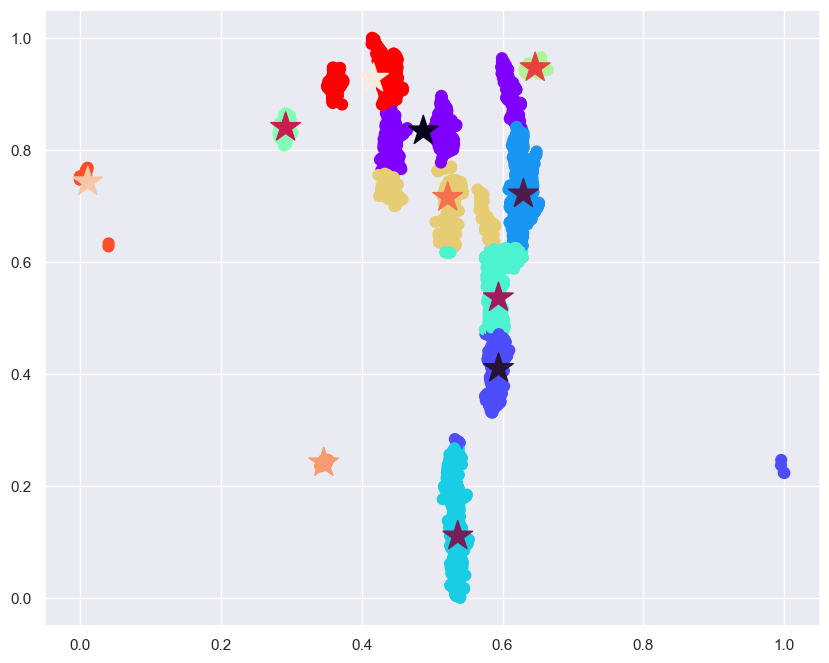

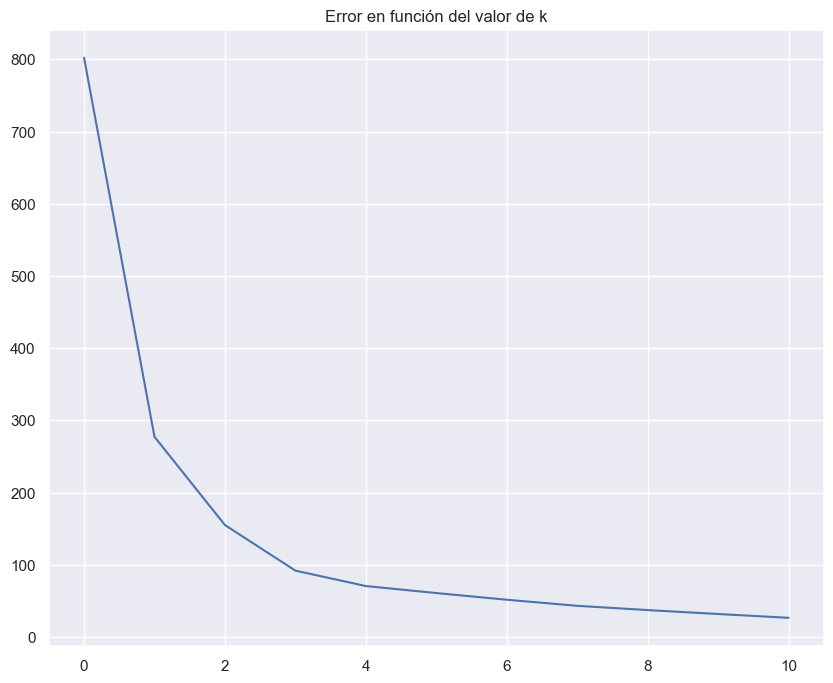

In [50]:
error = []
for k in np.arange(1,12):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=1234).fit(postures_pos1['User0'].drop(columns=['point','instance']))
    error.append(kmeans.inertia_)
    centros=kmeans.cluster_centers_
    etiquetas=kmeans.labels_
    print('k='+str(k))
    mostrar(postures_pos1['User0'].drop(columns=['point','instance']) , etiquetas, centros, i=0,j=1)

plt.figure(figsize=(10, 8))
plt.plot(error)
plt.title('Error en función del valor de k')
plt.show()


Como se puede comprobar, KMeans está muy limitado para este problema, debido a que forma clústers esféricos; también al operar con la media es sensible a los outliers que aparecen debido a los artefactos del sistema de captura; y si estos están muy cerca de alguno de los marcadores, puede darse el caso en el que no los detecte siquiera.

En cuanto al método del "codo", parece que la k óptima se encuentra en k=2, pero como sabemos por el problema esto no es así, para esta figura y este usuario en concreto aparecen siete de los once marcadores, así que parece, mirando los gráficos, que el mejor valor para k está entre 7 y 8 debido a los outliers. Si vemos los valores únicos de la variable punto, se obtiene:

In [51]:
np.unique(postures_pos1['User0'].iloc[:,1].values)

array([1., 2., 3., 4., 5., 6., 7., 8.])

Vemos que para esta postura y este usuario, sólo hay como máximo 8 puntos, por lo que se podría utilizar esta noción para automatizar el proceso.

Realizamos el mismo estudio para el usuario 4:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=1


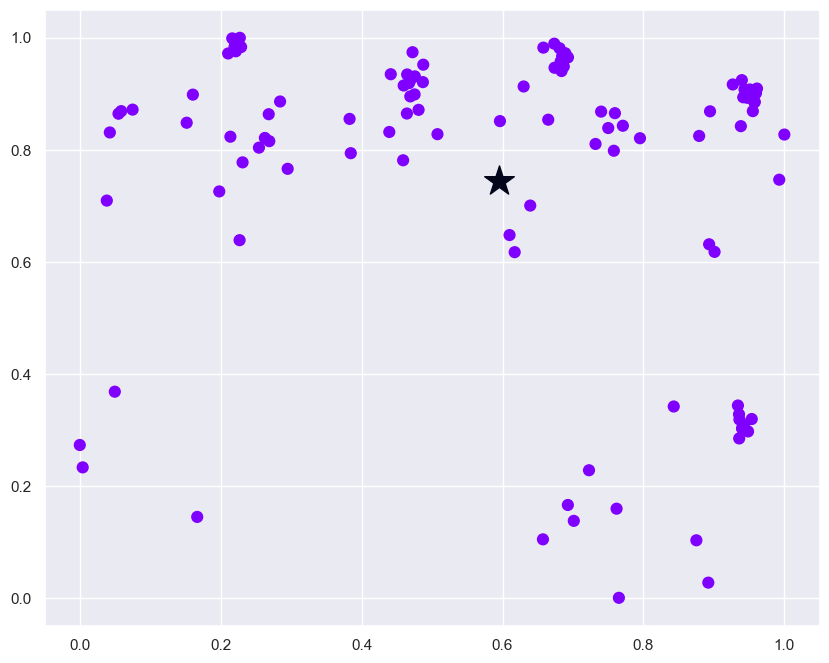

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=2


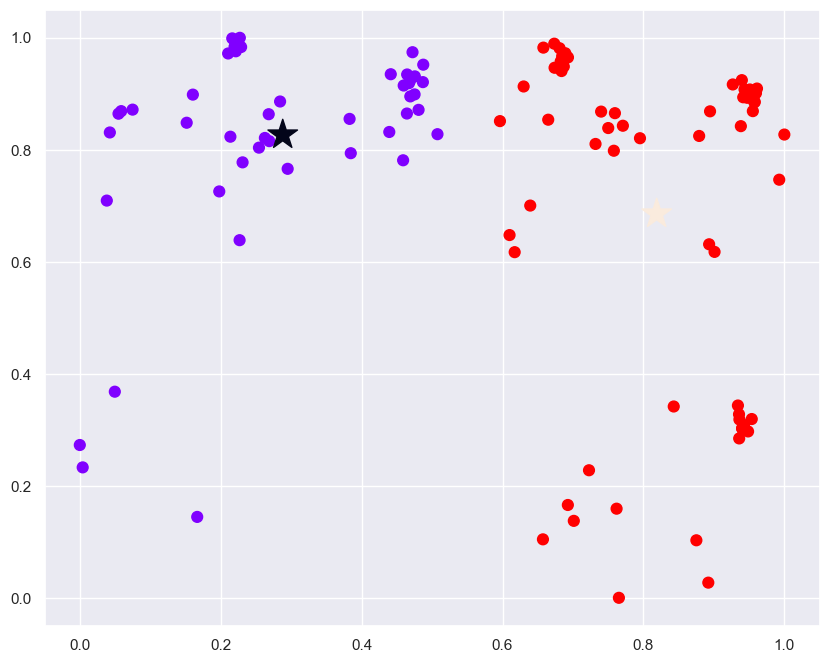

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=3


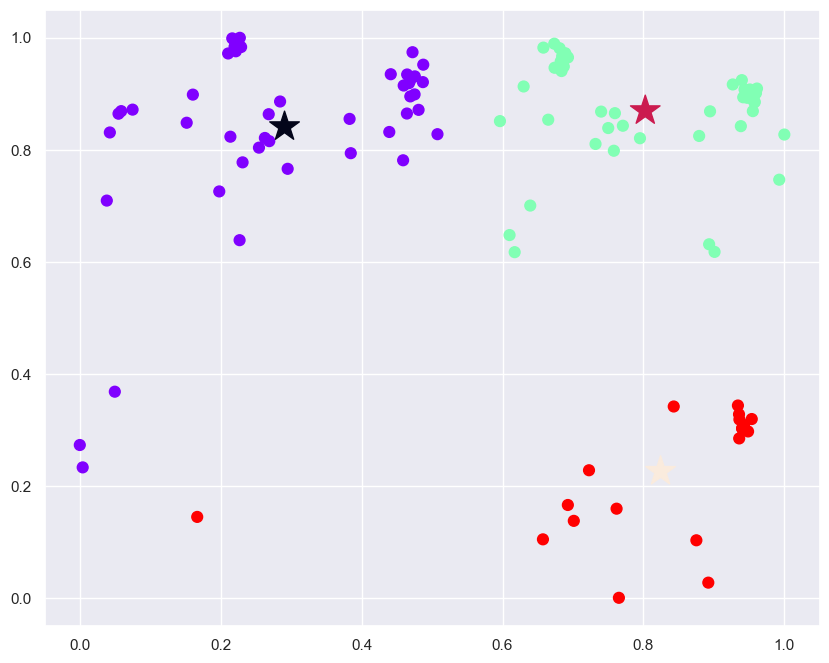

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=4


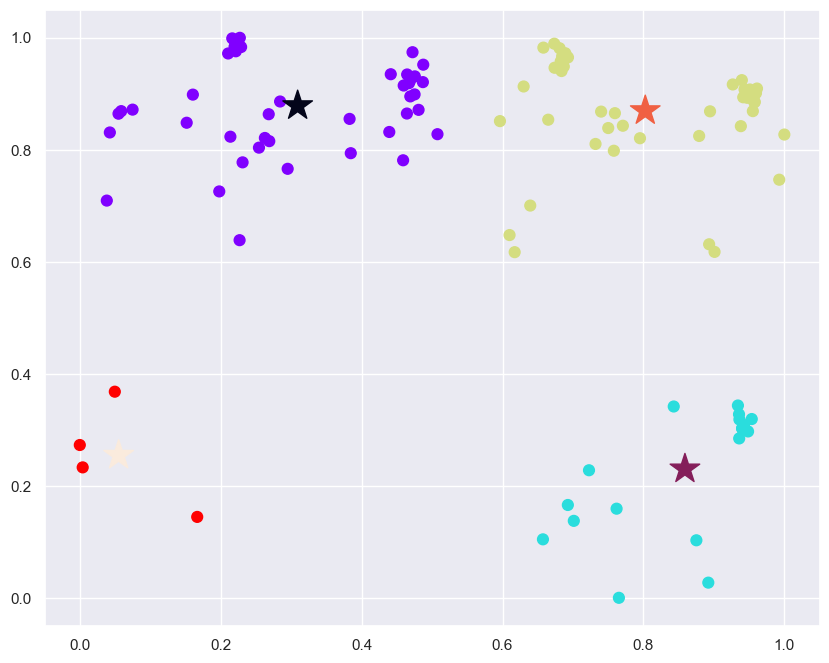

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=5


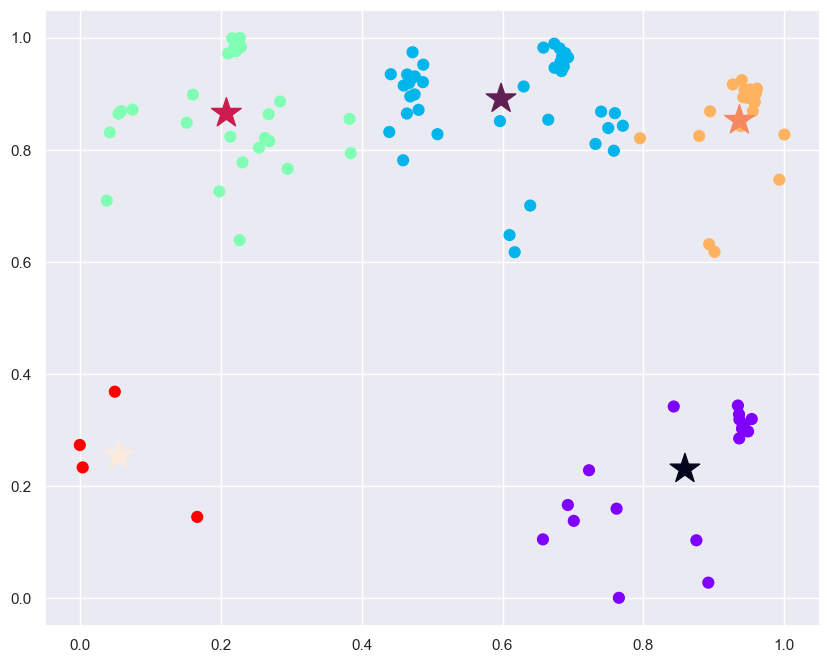

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=6


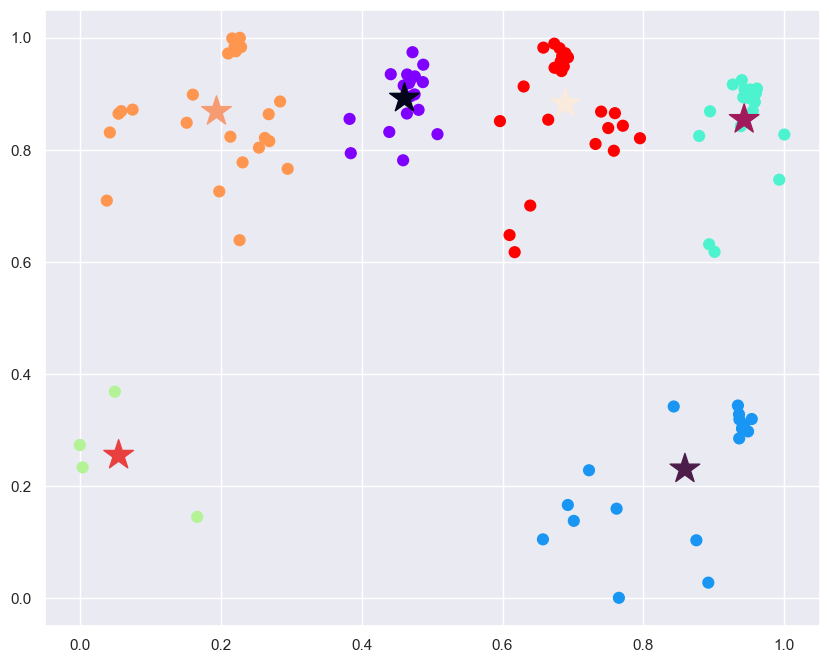

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=7


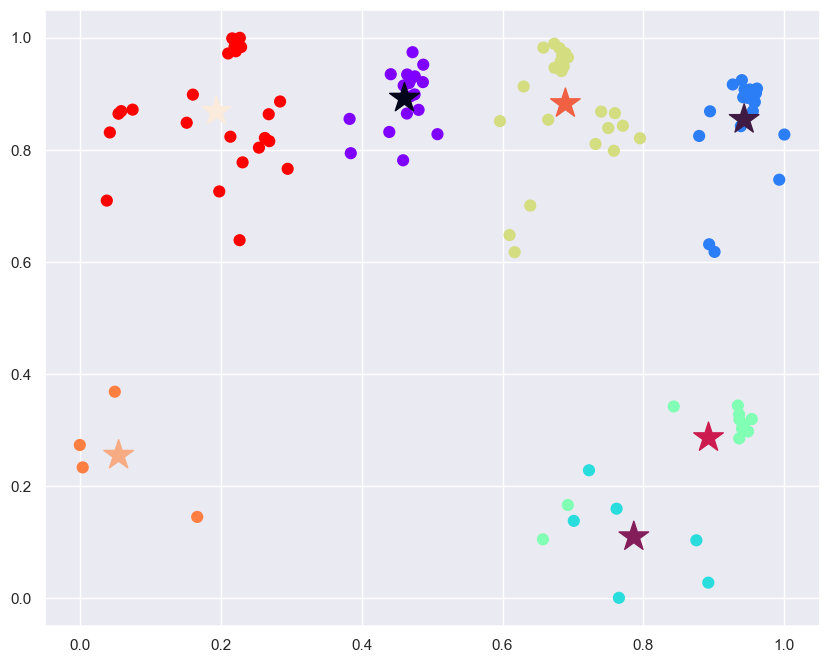

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=8


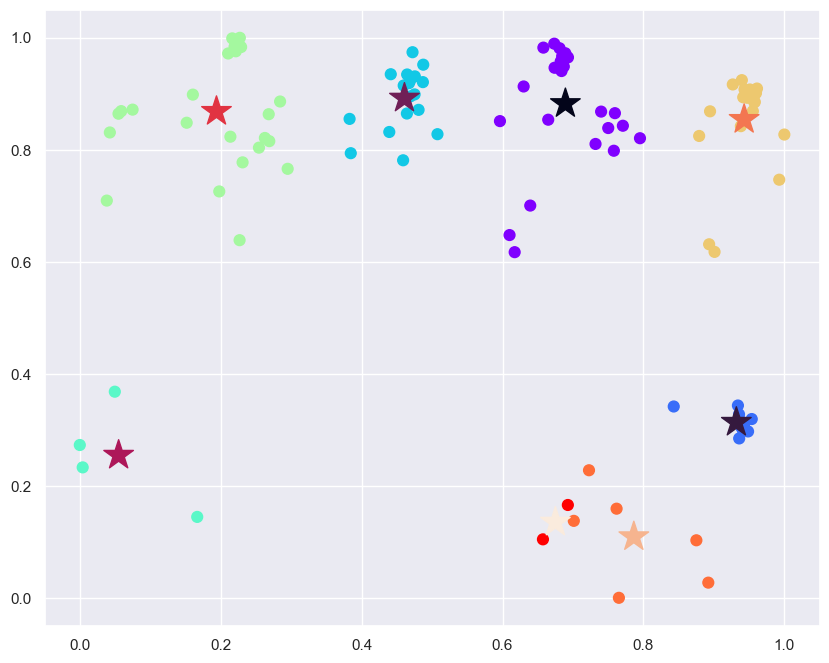

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=9


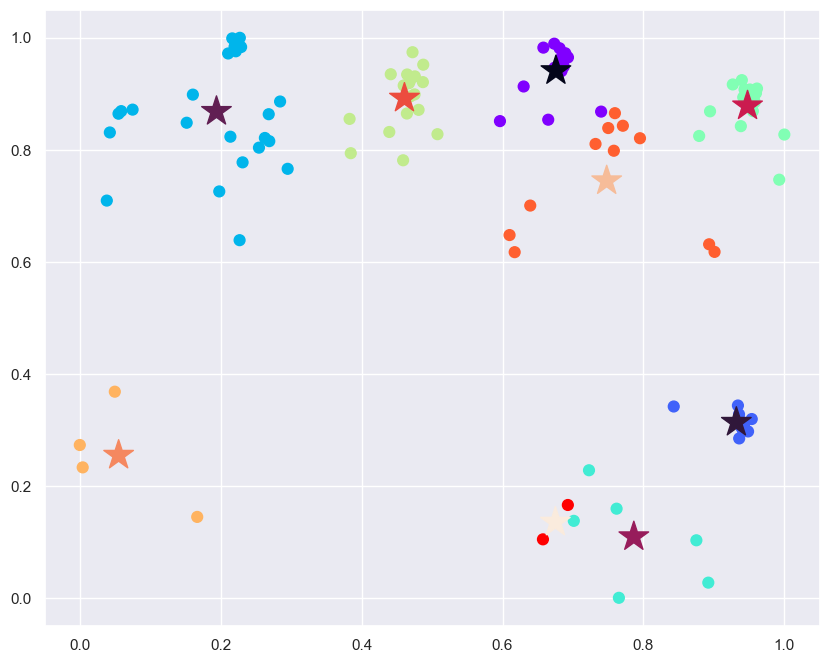

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=10


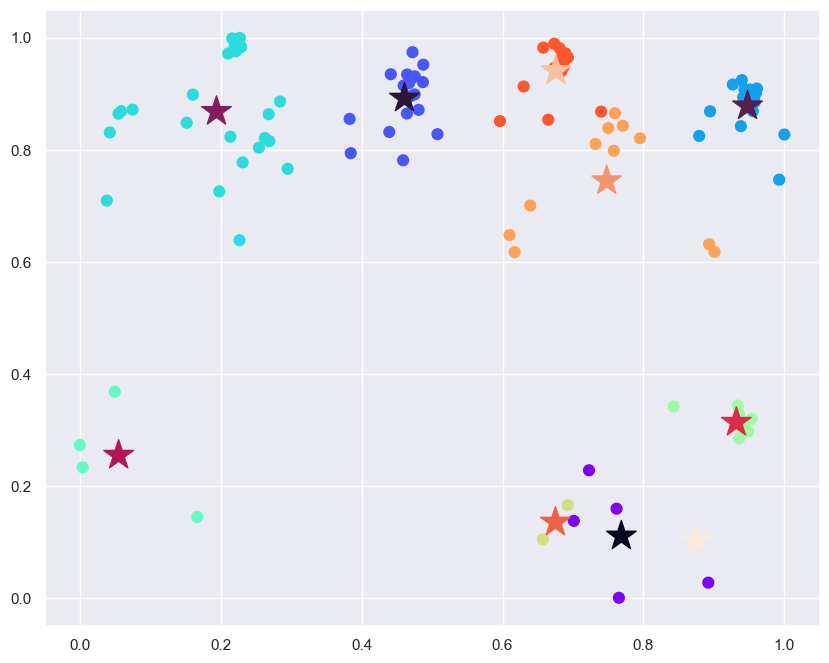

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=11


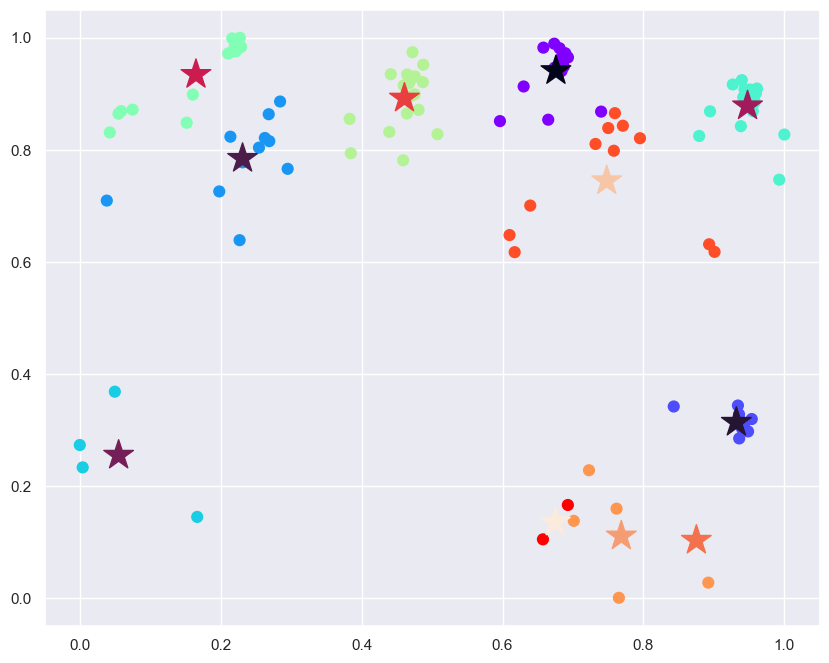

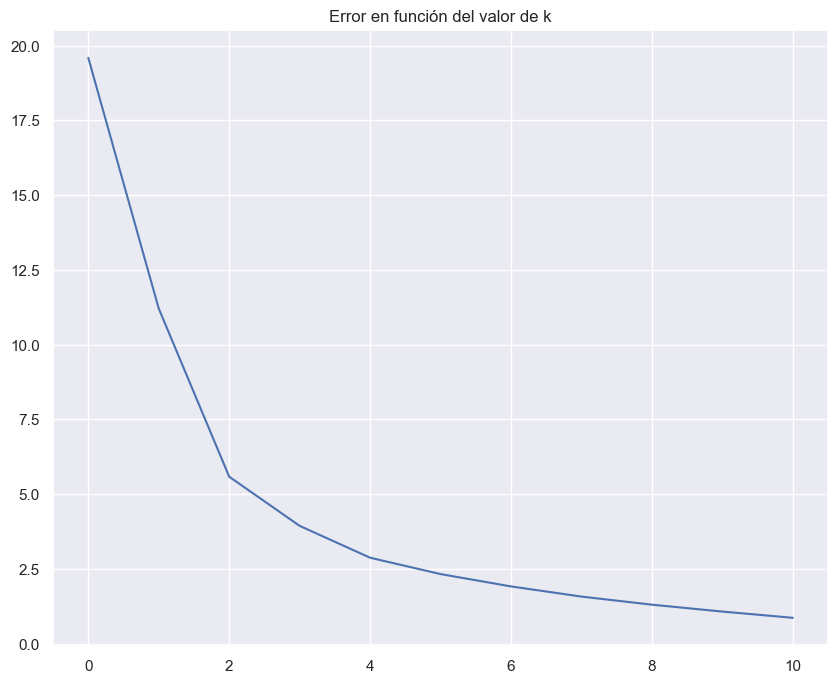

In [52]:
error = []
for k in np.arange(1,12):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=1234).fit(postures_pos1['User4'].drop(columns=['point','instance']))
    error.append(kmeans.inertia_)
    centros=kmeans.cluster_centers_
    etiquetas=kmeans.labels_
    print('k='+str(k))
    mostrar(postures_pos1['User4'].drop(columns=['point','instance']) , etiquetas, centros, i=0,j=1)

plt.figure(figsize=(10, 8))
plt.plot(error)
plt.title('Error en función del valor de k')
plt.show()

Para este caso, al haber pocas instancias, parece que KMeans funciona mejor, y mirando las gráficas parece que valor óptimo es k=5, donde cuatro clústeres agrupan puntos de posbles marcadores, y el clúster restante agrupa a los outliers. Como podemos comprobar para este usuario aparecen dos puntos para el pulgar y otros dos puntos para los dedos:

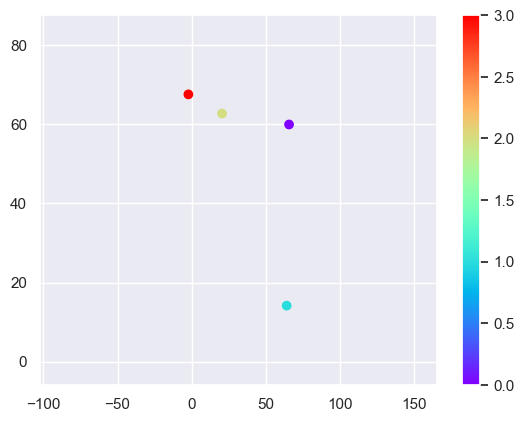

In [53]:
visualize2D(postures,[18293], 'X', 'Y', 11)

Si obtenemos los valores únicos de la variable punto como para el usuario anterior, tenemos:

In [54]:
np.unique(postures_pos1['User4'].iloc[:,1].values, return_counts=True)

(array([1., 2., 3., 4., 5.]), array([29, 29, 29, 22,  5], dtype=int64))

Por lo que parece que esta variable nos puede proporcionar la información para determinar el número de agrupaciones a formar.

Ahora quedaría estrapolar el proceso al resto de las posturas y usuarios, para ello se definirá una función que aplique el algoritmo y calcule las medidas de calidad mencionadas.

In [55]:
def KMeans_auto(df_dict):
    results_dict={}
    for key in df_dict:
        kmeans = KMeans(n_clusters=int(np.amax(np.unique(df_dict[key].iloc[:,1].values))), n_init=100, random_state=1234).fit(df_dict[key].drop(columns=['point','instance']))
        labels = kmeans.labels_
        dbs = davies_bouldin_score(df_dict[key].drop(columns=['point','instance']), labels)
        silhouette = silhouette_score(df_dict[key].drop(columns=['point','instance']), labels)
        results_dict[key] = {'labels':list(labels), 'davies_boulding_score':dbs, 'silhouette_score':silhouette}
    return results_dict

La función definida devuelve un diccionario como el que se le introduce como parámetro, donde cada llave corresponderá a cada usuario. Esta vez en lugar de tener un dataframe con los datos en cada valor, se devuelve un diccionario con las etiquetas obtenidas, y las medidas medias de Devies-Boulding y de silueta.

Lo que queda es llamar a la función para cada una de las posturas.

In [ ]:
postures_pos1_kmeans = KMeans_auto(postures_pos1)

In [56]:
postures_pos2_kmeans = KMeans_auto(postures_pos2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [ ]:
postures_pos3_kmeans = KMeans_auto(postures_pos3)

In [ ]:
postures_pos4_kmeans = KMeans_auto(postures_pos4)

In [ ]:
postures_pos5_kmeans = KMeans_auto(postures_pos5)

Comprobamos el resultado para uno de los usuarios con pocas instancias:

In [57]:
print(postures_pos2_kmeans['User7'])

{'labels': [7, 6, 4, 1, 3, 8, 5, 8, 7, 1, 6, 2, 1, 5, 1, 8, 7, 2, 3, 7, 1, 5, 4, 7, 8, 2, 7, 3, 0, 5, 8, 2, 6, 5, 7, 0, 3, 2, 6, 7, 3, 1, 2, 0, 2, 8, 5, 1, 7, 5, 2, 7, 3, 6, 6, 2, 1, 3, 3, 8, 0, 2, 5, 5, 9, 7, 4, 3, 6, 7, 2, 5, 6, 0, 0, 3, 5, 9, 2, 9, 3, 9, 5, 9, 5, 8, 3, 8, 0, 5, 3, 2, 9, 0, 9, 1, 1, 7, 3, 0, 8, 5, 2, 1, 7, 3, 7, 8, 6, 2, 7, 5, 7, 3, 6, 8, 0, 2, 7, 7, 5, 3, 2, 0, 4, 1, 7, 7, 3, 6, 1, 0, 2, 5, 8, 7, 7, 5, 6, 3, 8, 0, 2, 7, 6, 7, 6, 0, 3, 5, 8, 7, 7, 1, 5, 3, 2, 7, 7, 3, 5, 2, 6, 6, 1, 7, 7, 3, 2, 8, 6, 4, 5, 7, 2, 6, 3, 8, 3, 1, 5, 5, 2, 7, 3, 1, 6, 0, 5, 2, 2, 8, 6, 1, 3, 0, 1, 5, 5, 2, 8, 1, 1, 0, 7, 3, 7, 3, 5, 5, 6, 2, 1, 8, 0, 9, 0, 9, 3, 5, 5, 3, 2, 6, 8, 9, 0, 2, 7, 3, 5, 5, 1, 8, 5, 9, 5, 3, 9, 0, 3, 2, 8, 4, 7, 3, 5, 2, 4, 6, 0, 5, 7, 5, 5, 1, 1, 2, 3, 6, 0, 8, 8, 3, 1, 7, 5, 0, 8, 5, 5, 7, 0, 2, 1, 6, 3, 7, 7, 5, 3, 1, 2, 2, 3, 1, 8, 9, 5, 2, 7, 3, 1, 3, 0, 9, 4, 2, 3, 3, 9, 9, 2, 5, 8, 9, 5, 3, 5, 2, 4, 9, 3, 0, 5, 4, 3, 9, 0, 9, 9, 5, 8, 3, 5, 2, 9, 3, 9, 9

Ha funcionado correctamente. Comprobamos gráficamente los clústers formados para el usuario 7 y 5:

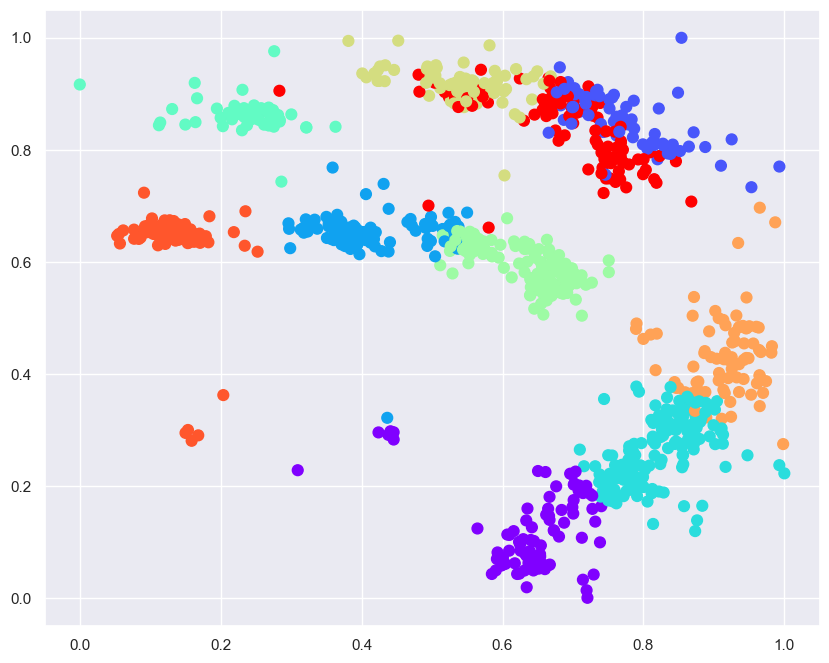

In [58]:
mostrar(postures_pos2['User7'].drop(columns=['point','instance']) , postures_pos2_kmeans['User7']['labels'], i=0,j=1)

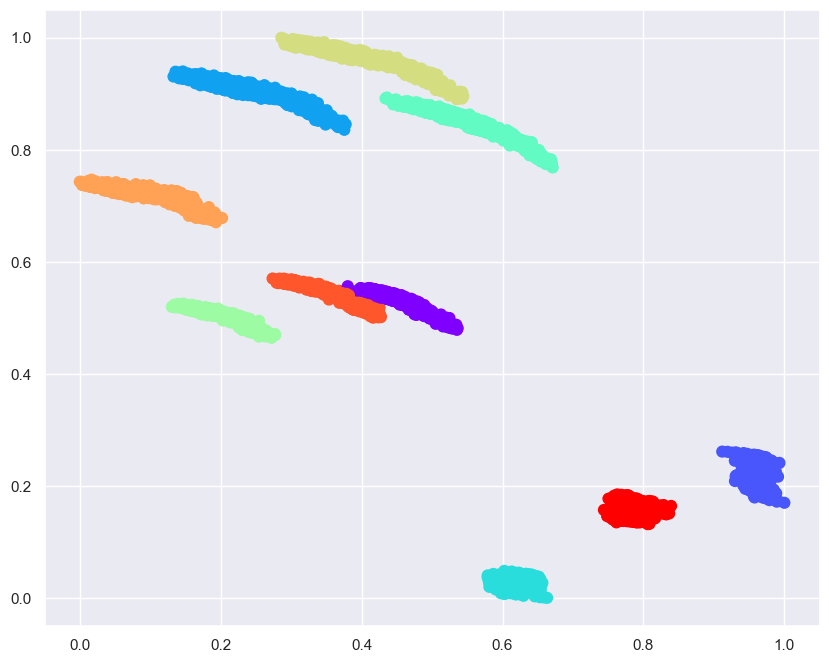

In [60]:
mostrar(postures_pos2['User5'].drop(columns=['point','instance']) , postures_pos2_kmeans['User5']['labels'], i=0,j=1)

Como se puede comprobar, para el usuario 5 se han obtenido resultados muy aceptables, mientras que para el 7 se ha conseguiodo diferenciar bien los marcadores del pulgar, pero algunos de los marcadores en los dedos no se han conseguido diferenciar. 

### DBSCAN

En este caso, para este algoritmo hay que determinar dos parámetros: el radio epsilón y el mínimo número de puntos que debe haber a una distancia menor que el radio para que un punto sea considerado como ejemplo central. De forma similar a KMeans, se utilizarán los ususarios 0 y 4 realizando la primera postura para hacer un ajuste manual, después se propondrá un método para deducir los valores óptimos y por último se intentará buscar una forma de generalizar la búsqueda de parámetros óptimos para aplicar el algoritmo a todas las posturas y usuarios. Como se ha mencionado anteriormente, se utilizará la distancia euclídea.

Empezando por el usuario 0, aplicamos DBSCAN con distintos valores:

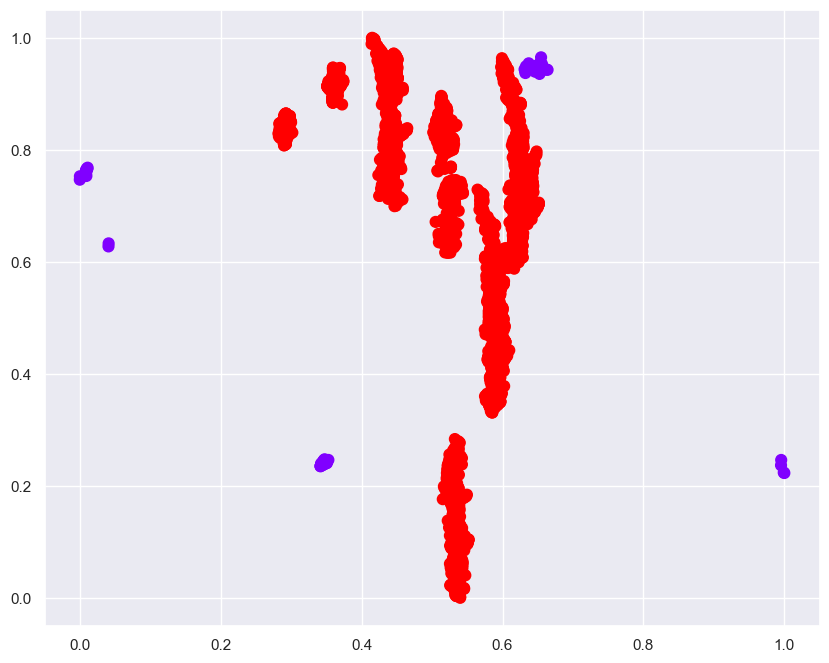

In [66]:
clustering = DBSCAN(eps=0.1, min_samples=70).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

El radio es demasiado grande, probamos reducirlo:

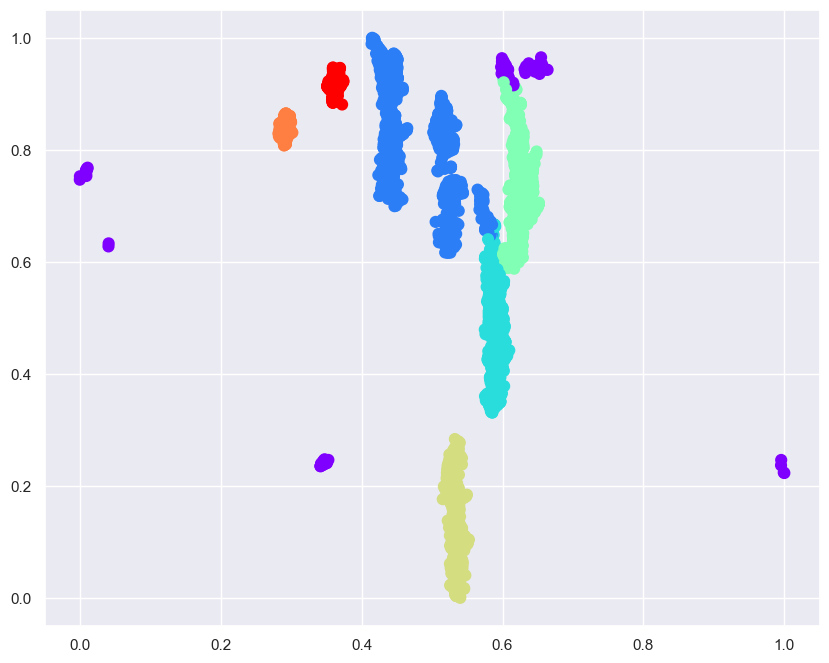

In [69]:
clustering = DBSCAN(eps=0.05, min_samples=70).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Mejora, pero sigue siendo demasiado grande, probamos reducirlo:

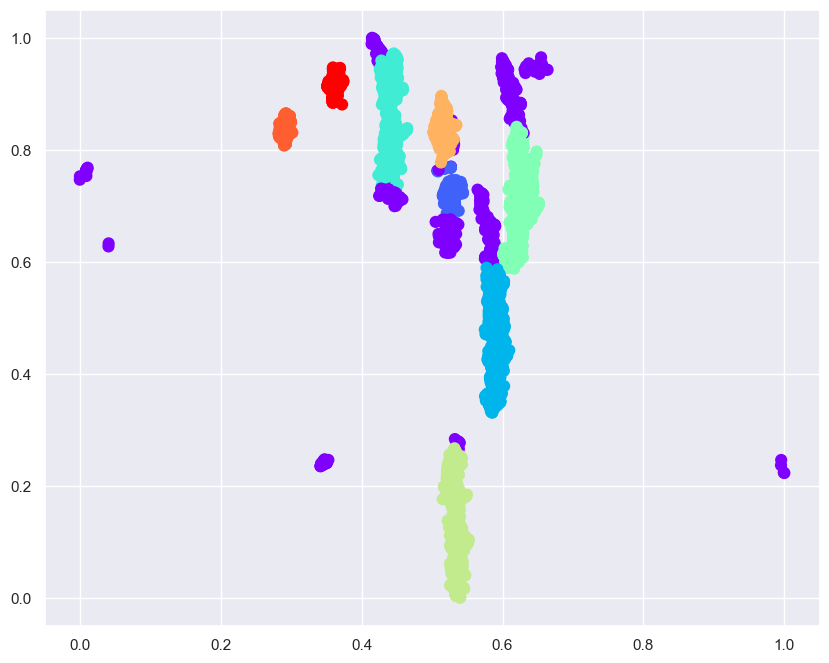

In [70]:
clustering = DBSCAN(eps=0.025, min_samples=70).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Ahora parece que el número de puntos mínimo es muy grande, reducimos ese parámetro:

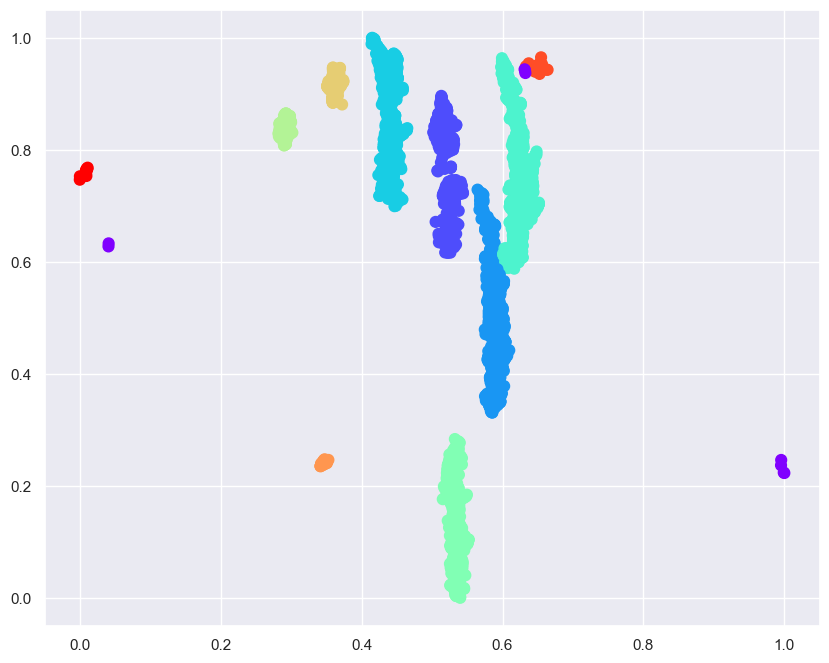

In [71]:
clustering = DBSCAN(eps=0.025, min_samples=10).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Como se puede apreciar, los clústers han sido separados correctamente, pero el valor de puntos mínimos que se ha escogido es tan bajo, que se han tomado agrupaciones de puntos atípicos generados por error como sus propios clusters. En principio esto no debería ser un problema grande debido a que estos clusters están constituidos por pocos puntos y se puede establecer un umbral para filtrarlos. Si obtenemos los valores únicos de las etiquetas y contamos las veces que aparecen, tenemos:

In [73]:
np.unique(etiquetas, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64),
 array([   9, 1287, 1837, 1745, 1828, 1323,  451,  417,   57,   30,   14],
       dtype=int64))

Si filtramos aquellos puntos que no pasen cierto umbral como frecuentes (por ejemplo el 1% del número de puntos totales):

In [75]:
np.unique(etiquetas, return_counts=True)[1]>0.01*postures_pos1['User0'].shape[0]

array([False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False])

Si se realiza la sima de este vector:


In [76]:
sum(np.unique(etiquetas, return_counts=True)[1]>0.01*postures_pos1['User0'].shape[0])

7

Se obtiene efectivamente el número de marcadores que se visualizan en la figura. También se podría pensar de aumentar el número de puntos mínimo para que estos outliers no sean detectados como clusters, pero si lo hacemos, por ejemplo aumentándolo a 60 que debería ser suficiente para aislar todos los datos atípicos:

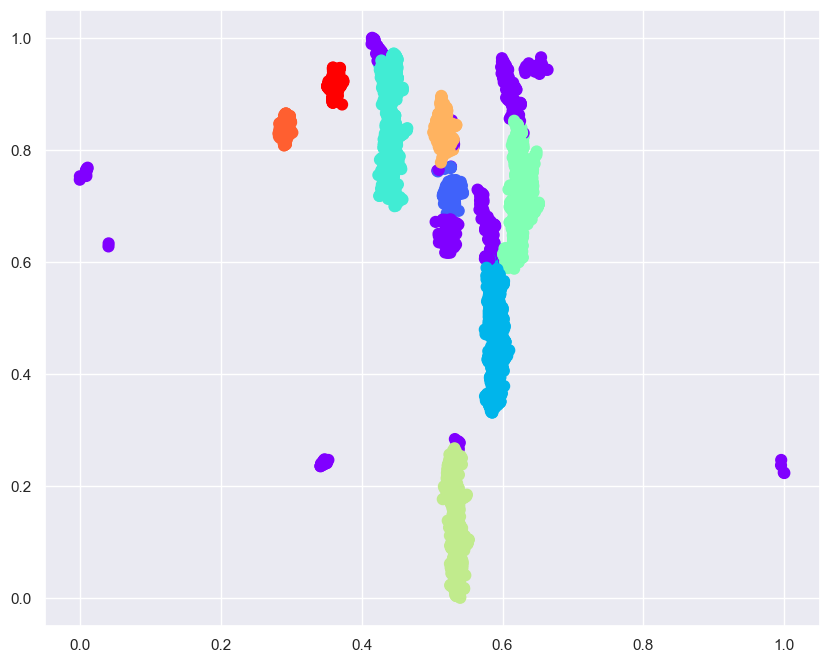

In [77]:
clustering = DBSCAN(eps=0.025, min_samples=60).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Tememos el problema de que en zonas de menor densidad, los clusters se separan. Es por ello que podemos fijar el número de puntos mínimo y después filtrar los clusters que se hayan formado con outliers con un umbral por su baja ocurrencia.

Para fijar el número de puntos mínimo se ha visto que para este caso un valor de 10 funciona bien, pero esto no tendría que ser siempre así. Una buena aproximación para fijar este parámetro sería utilizar el doble de número de dimensiones; es decir, $MinPts=2ndim$ (Sander et al., 1998). Para este problema, al estar trabajando en el espacio tridimensional, $ndim=3$ por lo que $MinPts=6$. En algunos casos donde el ruido sea mayor no habrá más remedio que utilizar un mayor número de puntos mínimo.

Probamos este valor con el mismo conjunto de puntos:

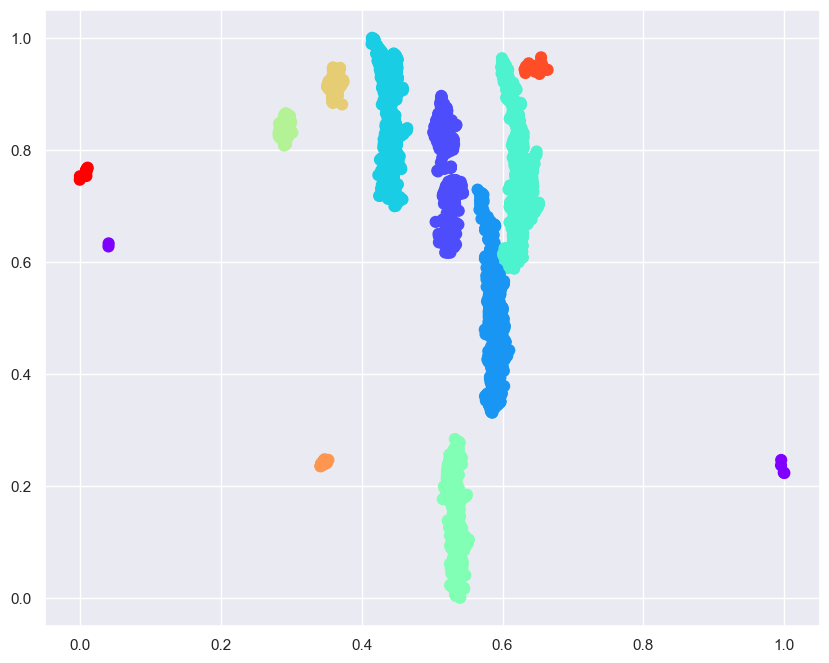

In [78]:
clustering = DBSCAN(eps=0.025, min_samples=6).fit(postures_pos1['User0'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User0'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Parece una buena aproximación y funciona bien para este caso.

En el mismo orden que para KMeans, probamos con el usuario 4:

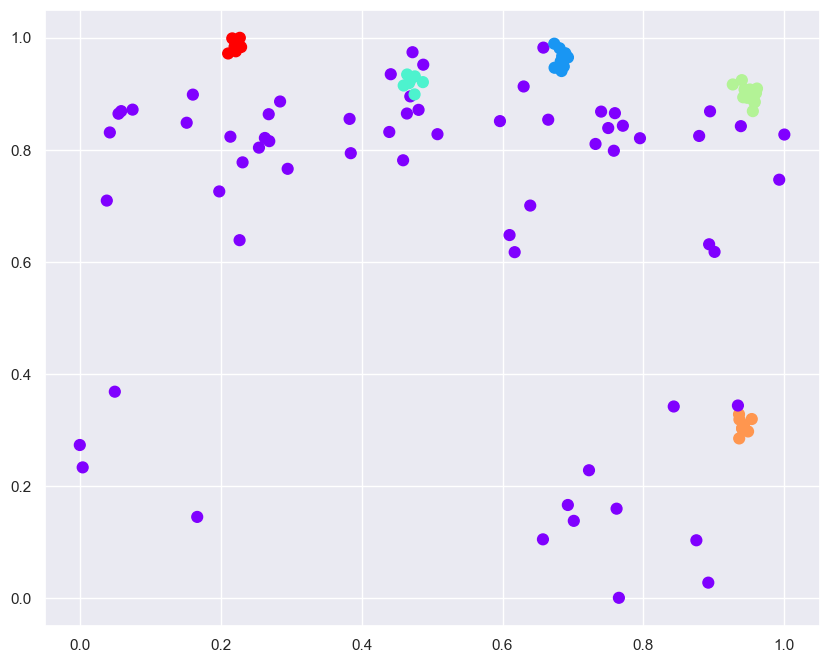

In [80]:
clustering = DBSCAN(eps=0.025, min_samples=6).fit(postures_pos1['User4'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User4'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Para este caso al disponer de menos instancias y por lo tanto de menos puntos, la densidad de los datos ha disminuido; o lo que es lo mismo los datos se encuentran más dispersos. Esto en parte se debe a que la normalización se ha hecho para cada postura y usuario por separado, pero también tiene una gran influencia la postura, por el número de marcadores que aparecen (no tenemos los mismos rangos cuando están todos los marcadores, a cuando sólo aparecen 4), y la cantidad de datos que se han tomado del usuario, porque cuantas más instancias se hayan tomado mayor será el desplazamiento de la mano si el usuario ha efectuado la postura con la mano en movimiento.

Probamos para este caso aumentar el valor del radio:

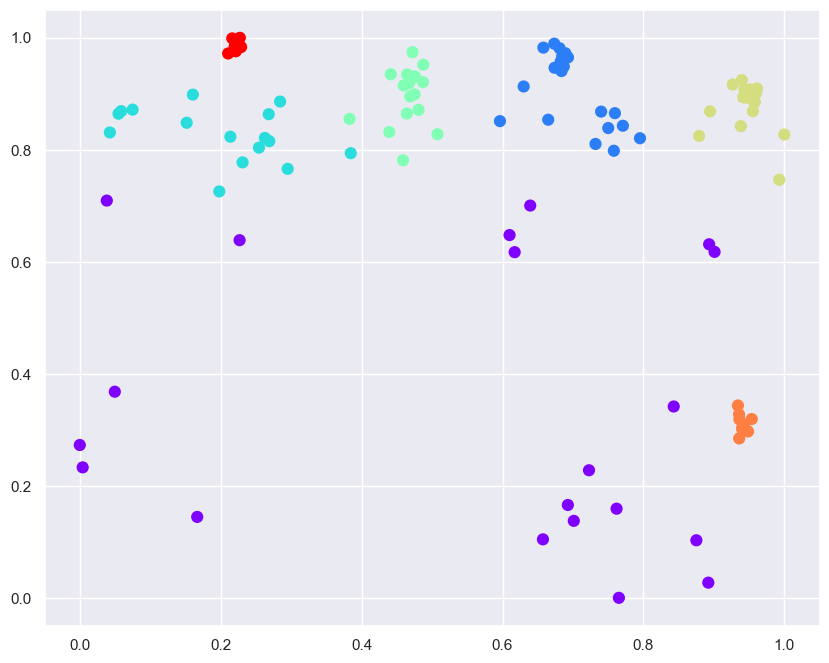

In [87]:
clustering = DBSCAN(eps=0.1, min_samples=6).fit(postures_pos1['User4'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User4'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

Aumentamos un poco más:

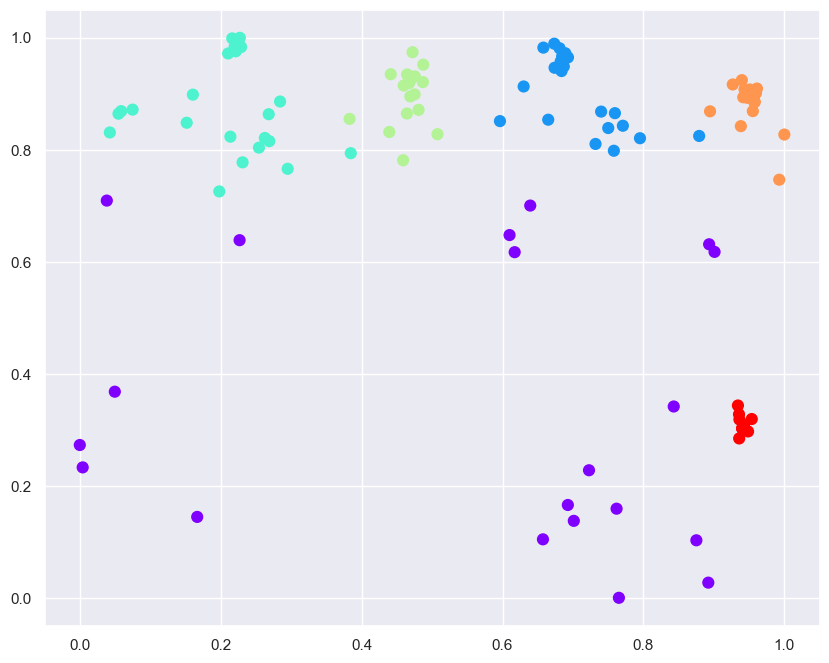

In [90]:
clustering = DBSCAN(eps=0.1125, min_samples=6).fit(postures_pos1['User4'].drop(columns=['point','instance']))
etiquetas=clustering.labels_
mostrar(postures_pos1['User4'].drop(columns=['point','instance']), etiquetas, i=0,j=1)

En este caso es difícil afinar correctamente al or óptimo, y se puede apreciar que puntos que son producidos por los marcadores, se quedan fuera del clúster y son tratados como datos atípicos. Podría decirse que para estos casos donde hay muy pocas instancias, y no hay "noción" de movimiento, KMeans funciona mejor.

Si se quisiese ajustar el algoritmo para el resto de posturas y usuarios, resultaría muy tedioso hacerlo manualmente, es por ello que se propone un método para encontrar los rangos de valores óptimos.

El método consiste en calcular la distancia media de un punto a sus k vecinos más cercanos (siendo k el mismo valor que emplearemos en el parámetro de $MinPts$), ordenar los valores de manera ascendente y representarlas distancias.

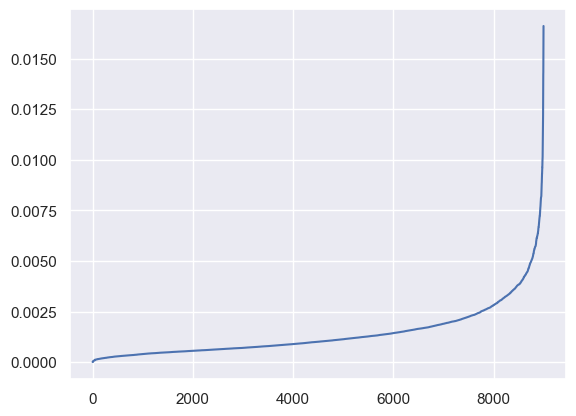

In [93]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(postures_pos1['User0'].drop(columns=['point','instance']))
distances, indices = neighbors_fit.kneighbors(postures_pos1['User0'].drop(columns=['point','instance']))

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


El método es parecido al método del "codo" en KMeans, en este caso vemos que el valor óptimo del radio está en torno a 0.0025 y 0.0045, lo mismo que se ha obtenido de manera experimental. Este método puede reducir la busqueda a unos pocos valores a probar.

Si lo aplicamos al usuario 4, tenemos:

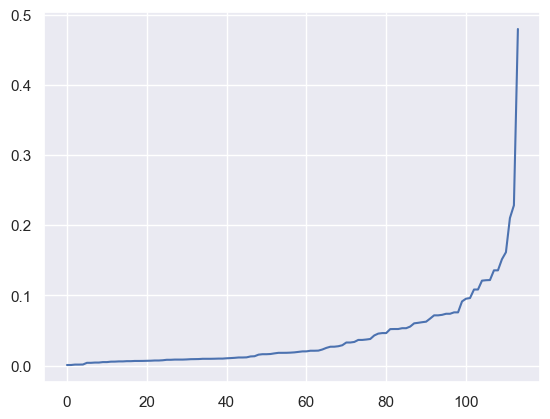

In [94]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(postures_pos1['User4'].drop(columns=['point','instance']))
distances, indices = neighbors_fit.kneighbors(postures_pos1['User4'].drop(columns=['point','instance']))

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


Debido al número reducido de instancias para este caso, es más complicado distinguir el "codo". Se podría decir que está en torno a 0.1, que es un valor muy cercano al que hemos obtenido de forma experimental.

LLegados a este punto, sólo queda encontrar una manera de aplicar automáticamente DBSCAN al resto de posturas y usuarios. Pueden existir otras soluciones, pero la solución encontrada al problema se basa en el conocimiento previo del número de puntos para cada postura.

El método se basará en una búsqueda de exahustiva del parámetro de radio, utilizando como condición el número de puntos que cabe esperar con una tolerancia.

Sabemos el número de puntos únicos que puede tener un conjunto de datos:

In [126]:
np.unique(postures_pos1['User4'].iloc[:,1].values)

array([1., 2., 3., 4., 5.])

También podemos comparar el número de etiquetas con valores únicos que se forman a cierto umbral:

In [113]:
np.unique(etiquetas, return_counts=True)[1]>0.01*postures_pos1['User4'].shape[0]

array([ True,  True,  True,  True,  True,  True])

Si combinamos estas nociones, se puede definir una función que pruebe distintos valores para el radio, y solamente conserve aquellos que cumplan que la suma de clusters con puntos frecuentes, sea igual al número de puntos que se observan.

In [142]:
def DBSCAN_auto(df, tol=0.01):
    optimum_radius = []
    for radius in np.arange(0.01, 0.4,0.001):
        clustering = DBSCAN(eps=radius, min_samples=6).fit(df.drop(columns=['point','instance']))
        labels=clustering.labels_
        if sum(np.unique(labels, return_counts=True)[1]>tol*len(labels)) == sum(np.unique(df.iloc[:,1].values, return_counts=True)[1]>0.01*df.shape[0]):
            optimum_radius.append(radius)
        
    clustering = DBSCAN(eps=np.mean(optimum_radius), min_samples=6).fit(df.drop(columns=['point','instance']))
    etiquetas=clustering.labels_
    return {'labels':etiquetas,'davies_boulding_score':davies_bouldin_score(df,etiquetas), 'silhouette_score':silhouette_score(df,etiquetas)}

La función es bastante costosa, por lo que solamente se aplicará al usuario 5 y 7 para la postura 2, y así poder comparar los resultados obtenidos con kmeans.

In [143]:
postures_pos2_user5 = DBSCAN_auto(postures_pos2['User5'])
postures_pos2_user7 = DBSCAN_auto(postures_pos2['User7'])

Mostramos los resultados:

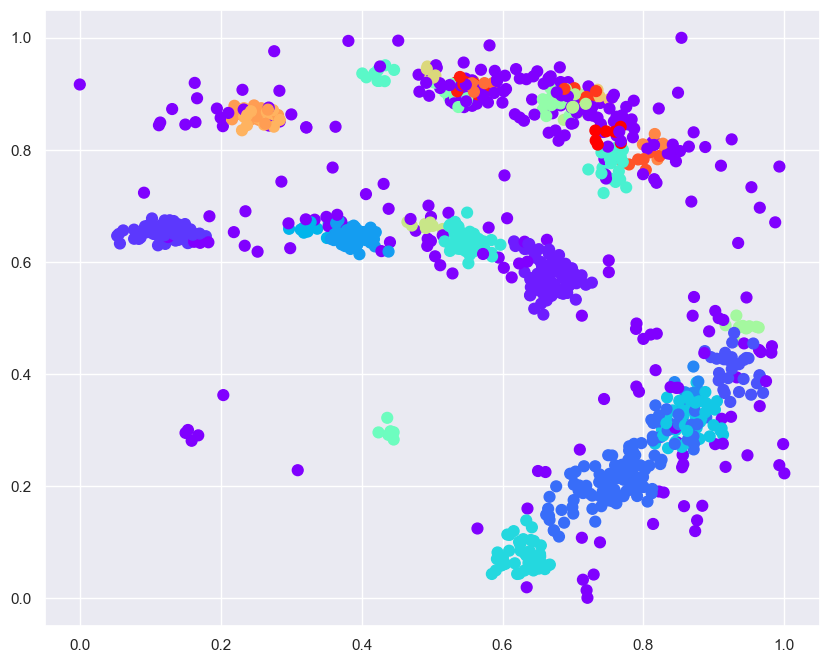

In [144]:
mostrar(postures_pos2['User7'].drop(columns=['point','instance']), postures_pos2_user7['labels'], i=0,j=1)

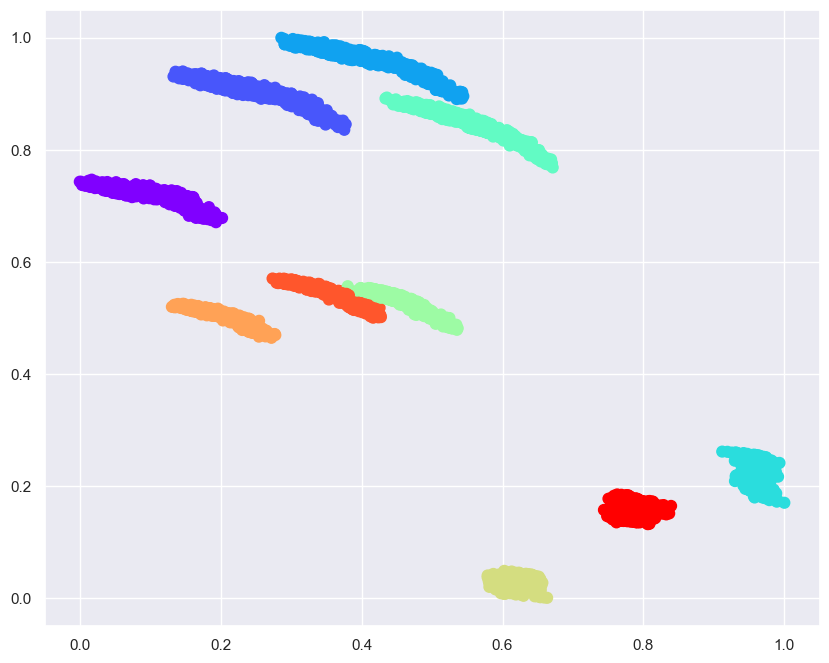

In [145]:
mostrar(postures_pos2['User5'].drop(columns=['point','instance']), postures_pos2_user5['labels'], i=0,j=1)

Como era de esperar, para el ususario 5 se han obtenido unos buenos resultados mientras que para el usuario 7, al tener los datos una densidad muy baja y muchos puntos dispersos el algoritmo ha tenido mayor dificultad en distinguir los marcadores. Parece que para este caso kmeans ha podido clasificar los marcadores del pulgar mejor, pero DBSCAN ha diferenciado mejor los el marcador central de cada dedo.

No tendría mucho sentido comparar las medidas de calidad entre los dos algoritmos, ya que ambos aglomeran de forma muy diferente y es difícil encontrar una medida que sirva para evaluar DBSCAN. A la hora de comparar es mejor ver los resultados gráficos. Además las medidas de calidad se utilizan sobretodo para encontrar los valores óptimos de los parámetros de los algoritmos de clustering, que para nuestro problema ya estaba definido por el número de marcadores. Aún así, por curiosidad veamos las medidas tomadas para el usuario 5 y 7 en la segunda postura.

Para KMeans se ha obtenido para el usuario 5:

In [149]:
print('davies boulding score: '+str(postures_pos2_kmeans['User5']['davies_boulding_score'])+', silhouette score: '
      +str(postures_pos2_kmeans['User5']['silhouette_score']))

davies boulding score: 0.39732221113444643, silhouette score: 0.7243086722342941


Para el usuario 7:

In [151]:
print('davies boulding score: '+str(postures_pos2_kmeans['User7']['davies_boulding_score'])+', silhouette score: '
      +str(postures_pos2_kmeans['User7']['silhouette_score']))

davies boulding score: 0.8303661302294254, silhouette score: 0.42356975637748834


Para DBSCAN se ha obtenido para el usuario 5:

In [153]:
print('davies boulding score: '+str(postures_pos2_user5['davies_boulding_score'])+', silhouette score: '
      +str(postures_pos2_user5['silhouette_score']))

davies boulding score: 857.1061157927963, silhouette score: -0.09971466358767167


Para el usuario 7:

In [156]:
print('davies boulding score: '+str(postures_pos2_user7['davies_boulding_score'])+', silhouette score: '
      +str(postures_pos2_user7['silhouette_score']))

davies boulding score: 46.590515397774595, silhouette score: -0.45499662839748606


Según las métricas, DBSCAN ha hecho clusters de muy baja calidad, pero por lo que vemos en los gráficos sabemos que no es del todo cierto. Como se ha mencionado antes no tiene mucho sentido evaluar este algoritmo con medidas de calidad.

En cuanto a KMeans, para el ususario 5 se han obtenido mejores medidas de calidad, esto no es ninguna sorpresa viendo los resultados obtenidos en las gráficas.

## Conclusiones

Tras la fase de experimentación y en base a los resultados obtenidos, se pueden formular las siguietnes conclusiones:
* KMeans funciona bien para los casos en los que el número de instancias es reducido. Pero tiende a actuar peor en los casos donde hay grupos de outliers al utilizar la media y en aquellos casos donde haya cierta noción de movimiento, ya que tiende a formar esferas.
* DBSCAN funciona bien para aquellos casos donde hay un número de instancias suficiente, de lo contrario no actúa muy bien debido a la poca densidad de puntos y el posible solapamiento. Además no esta limitado a formar clusters esféricos por lo que da buenos resultados en aquellos casos en los que los marcadores se desplazan debido al movimiento de la mano.
En cuanto a la implementación:
* KMeans se ha podido implementar y generalizar al resto de casos con mayor facilidad, debido en gran parte a su simplicidad y el control que se tiene sobre el número de clusters que se forman.
* DBSCAN ha sido más complicado de generalizar, debido a que las densidades eran diferentes para cada caso y no es tan sencillo determinar el número de clusters que se forman, también como punto negativo está su elevado coste computacional. La mejor manera de aplicar este algoritmo al dataset sería buscando los parámetros experimentalmente, o utilizando el método propuesto.

En definitiva, el problema ha sido bastante desafiante, no solamente por su naturaleza, si no por tener que buscar una manera de formatear los datos para aplicar clústering y buscar soluciones originales a un problema tan específico. Sería interesante analizar como se comportaría el dataset ante una clasificación supervisada de las posturas con los marcadores reordenados por las soluciones propuestas.

## Bibliografía

* UCI Machine Learning Repository: Motion Capture Hand Postures Data Set, https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures. 
* “Falanges Medias.” Wikipedia, Wikimedia Foundation, 2 Sept. 2021, https://es.wikipedia.org/wiki/Falanges_medias. 
* Mullin, Tara. “DBSCAN - Overview, Example, &amp; Evaluation.” Medium, Medium, 15 July 2020, https://medium.com/@tarammullin/dbscan-2788cfce9389. 
* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
